# Figures 

## Science
* [slope/nu_obs vs. duration](#Drift-normalized-by-observing-frequency-vs.-Burst-Duration)
* tw vs nuobs
* Slope vs. frequency
* slope/nu^2 vs nu
* bandiwdth vs nu

## Methodology
* SNR vs. burst duration
* Slope vs. time resolution
* DM vs. slope



# Drift normalized by observing frequency vs. Burst Duration

## FRB20121102A

Loading...
results/FRB121102_michilli_924rows_Jul07.csv
results/GajjarFRB121102_1092rows_Jul16.csv
results/FRB121102_oostrum_1025rows_Jul07.csv
results/FRB121102_aggarwal_4785rows_Jul07.csv
results/FRB121102_Li_419rows_Jul07.csv
results/FRB121102_Li_waittimes_1758rows_Jul07.csv

# FRB20121102A Michilli et al. (2018):
>> DM range after maximizing bursts: 555.0 - 560.0 pc/cm3
>> num bursts remaining = 19

# FRB20121102A Gajjar et al. (2018):
>> DM range after maximizing bursts: 555.0 - 563.5 pc/cm3
>> num bursts remaining = 21

# FRB20121102A Oostrum et al. (2020):
>> DM range after maximizing bursts: 555.0 - 563.0 pc/cm3
>> num bursts remaining = 23

# FRB20121102A Aggarwal et al. (2021):
>> DM range after maximizing bursts: 555.0 - 560.5 pc/cm3
>> num bursts remaining = 63

# FRB20121102A Li et al. (2021):
>> DM range after maximizing bursts: 555.0 - 562.0 pc/cm3
>> num bursts remaining = 42
FRB20121102A Michilli et al. (2018) (0.057 - 0.105) $t_w^{-1}$
FRB20121102A Gajjar et al. (2018

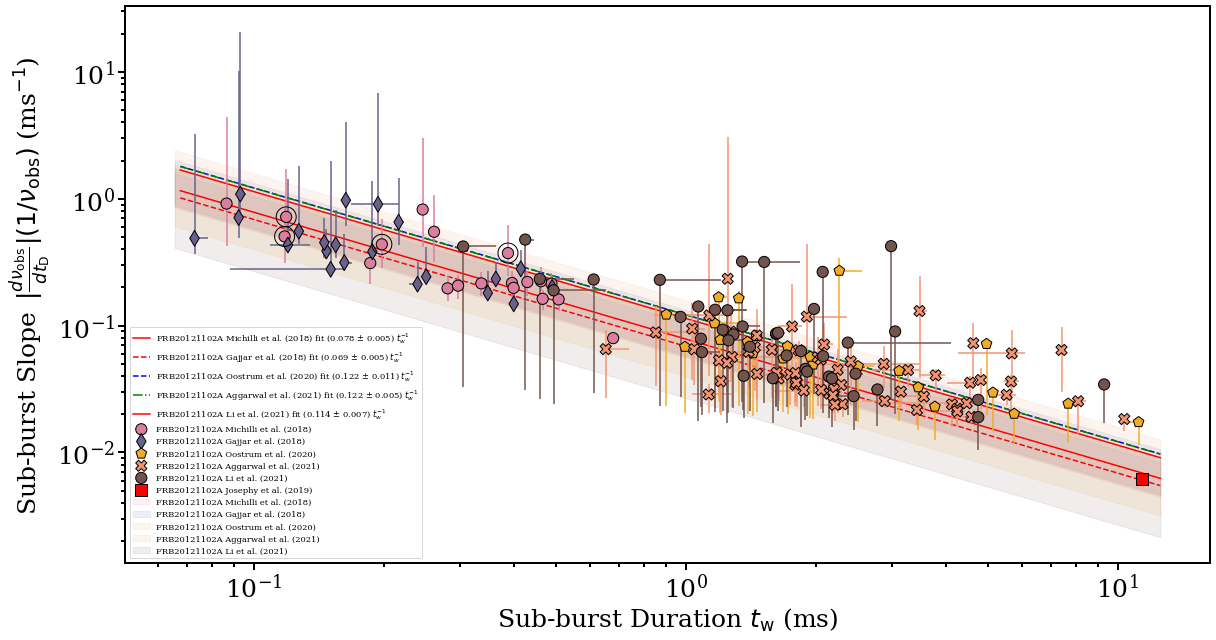

In [226]:
#### TEST For rewrite
# from frbrepeaters import driftlaw
import driftrate, driftlaw
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
import warnings, importlib
import scipy
warnings.filterwarnings('ignore')
importlib.reload(driftlaw)

pd.options.mode.chained_assignment = None  # default='warn'
pd.set_option('display.max_rows', None)
%matplotlib inline

chanspaces = [True, True, True, True, True, False, False, False]
chanspaces = [False, False, False, False, False, False, False]
sources_filenames = [ # Analytical measurements
    "results/FRB121102_michilli_924rows_Jul07.csv",
    'results/GajjarFRB121102_1092rows_Jul16.csv', 
    'results/FRB121102_oostrum_1025rows_Jul07.csv', 
    'results/FRB121102_aggarwal_4785rows_Jul07.csv',
    'results/FRB121102_Li_419rows_Jul07.csv',
    'results/FRB121102_Li_waittimes_1758rows_Jul07.csv'
]
# sources_filenames = [ # Sliced autocorr measurements
#     "results/FRB121102_michilli_924rows_Jul06.csv",
#     'results/FRB121102_oostrum_1025rows_Jul06.csv',
#     'results/FRB121102_aggarwal_4785rows_Jul06.csv',
#     'results/GajjarFRB121102_672rows_Jul06.csv',
#     'results/FRB121102_Li_419rows_Jul06.csv',
#     'results/FRB121102_Li_waittimes_1758rows_Jul06.csv'
# ]
# sources_filenames = [ # Summed autocorr measurements
#     "results/FRB121102_michilli_924rows_Jul07_summed.csv",
#     'results/FRB121102_oostrum_1025rows_Jul07_summed.csv',
#     'results/FRB121102_aggarwal_4785rows_Jul07_summed.csv',
#     'results/GajjarFRB121102_672rows_Jul07_summed.csv',
#     'results/FRB121102_Li_419rows_Jul07_summed.csv',
#     'results/FRB121102_Li_waittimes_1758rows_Jul07_summed.csv'
# ]

sources = []

print("Loading...")
for sfile, chanspace in zip(sources_filenames, chanspaces):
    df = pd.read_csv(sfile)
    df = df.set_index("name")
    print(sfile)
    df = driftlaw.computeModelDetails(df, channelSpaceDuration=chanspace)
    sources.append(df)

names = [
    'FRB20121102A Michilli et al. (2018)', 
    'FRB20121102A Gajjar et al. (2018)',
    'FRB20121102A Oostrum et al. (2020)',
    'FRB20121102A Aggarwal et al. (2021)',
    'FRB20121102A Li et al. (2021)',
    'FRB20121102A Li_waits et al. (2021)',
]
annotations = [
    [0, 1, 2, 3, 4, 5],
    [],
    [],
    [],
    [],
    [],
    # []
]
dmlimited = [
    ['M003', 'M005', 'M006', 'M014'],
    [],
    [],
    [],
    [],
    [],
]

# ['B016', 'B028', 'B056', 'B109', 'B076', 'B079', 'B082', 'B133', 'B093', 'B091', 'B121', 'B128', 'B005', 'B007', 'B008', 'B020', 'B022', 'B024', 'B029', 'B033?', 'B038?', 'B039', 'B041', 'B045', 'B048', 'B048_a', 'B048_b', 'B051', 'B055', 'B060', 'B060_a', 'B060_b', 'B064', 'B068', 'B069', 'B070', 'B071', 'B077', 'B078', 'B083', 'B086', 'B088_a', 'B088_b', 'B097', 'B099', 'B103', 'B107', 'B115?', 'B127', 'B131']
exclusions = [
    ['M009', 'M010', 'M013'],
    ['11A', '11B', '12A', '12B', '11G'],
    ['R1_B10', 'R1_B09'], # ['R1_B08', 'R1_B09', R1_B10', 'R1_B12']
    ['B016', 'B028', 'B056', 'B109', 'B076', 'B079', 'B082', 'B133', 'B093', 'B091', 'B121', 'B128', 'B005', 'B008', 'B020', 'B022', 'B024', 'B029', 'B032', 'B032_b', 'B033', 'B038', 'B039', 'B041', 'B045', 'B048', 'B048_a', 'B048_b', 'B051', 'B055', 'B060', 'B060_a', 'B060_b', 'B064', 'B068', 'B069', 'B070', 'B071', 'B077', 'B078', 'B083', 'B086', 'B088_a', 'B088_b', 'B097', 'B099', 'B103', 'B107', 'B115', 'B127', 'B131'],
    [],
    [
        'FRB121102_tracking-M01_0576',
        'FRB121102_tracking-M01_1180',#
        'FRB121102_tracking-M01_0055',
        'FRB121102_tracking-M01_0095',
        'FRB121102_tracking-M01_0163',
        'FRB121102_tracking-M01_0264',
        'FRB121102_tracking-M01_0388',
        'FRB121102_tracking-M01_0415',
        'FRB121102_tracking-M01_0487',
        'FRB121102_tracking-M01_0576',
        'FRB121102_tracking-M01_0634',
        'FRB121102_tracking-M01_0630' ## Added july 17 2022
    ]
]


targetDMs = [558.816263157895, 555.0, 555.0, 555.0]
targetDMs = [557.048789473684, 563.5, 559.5, 555.0]
targetDMs = [557.637947368421, 563.5, 559.5, 556.0, 563.5]
targetDMs = [557.637947368421, 560, 559.5, 556.0, 563.5]
targetDMs = [557.637947368421, 563.5, 559.5, 556.0, 560.5]
targetDMs = [557.637947368421, 563.5, 559.5, 556.0, 561.5, 561.5]
targetDMs = [558.5, 563.5, 559.5, 556.0, 561.5, 561.5]
targetDMs = [558.0, 563.5, 559.5, 556.0, 561.5, 561.5]
targetDMs = [558.0, 563.5, 559.5, 556.0, 561.5, 562.0]
targetDMs = [558.0, 562.5, 559.5, 556.0, 561.5, 562.0]
targetDMs = [558.0, 561.0, 559.5, 556.0, 561.5, 562.0]
targetDMs = [558.0, 561.0, 559.5, 556.0, 561.5, 562.0]
targetDMs = [558.0, 556.0, 561.0, 559.5, 562.0] # combined Li, switched gajjar
targetDMs = [558.0, 556.0, 563.0, 559.5, 562.0]
targetDMs = [558.0, 557.5, 563.0, 559.5, 562.0]

### Combine Li
sources = sources[:-2] + [pd.concat(sources[-2:])]
names = names[:-1]
annotations = annotations[:-1]
dmlimited = dmlimited[:-1]
exclusions = exclusions[:-2] + [exclusions[-2] + exclusions[-1]]
###

tagColors = ['r', 'b', 'g', 'y', 'c']
tagColors = ['#042940','#005C53','#9FC131','#DBF227','#D6D58E']
tagColors = ['#4B72A6','#99BFF2','#63A693','#ADD96C','#D8F2A0']
tagColors = ['#D97E9F','#67618C','#F2AB27','#F29472','#73544D']
bakeddata, fitdata, sources, extradata = driftlaw.bakeMeasurements(sources, names, exclusions, targetDMs, logging=False, tagColors=tagColors)
Bconstants = extradata['Bconstants']

# bakeddata['frames'][0] = pd.concat([bakeddata['frames'][0], bakeddata['frames'][1]])
# del bakeddata['frames'][1]
# del bakeddata['labels'][1]
# annotatei = [-3]
annotatei = []
fitextents = [0.06764309437015809, 12.54]
ax, _ = driftlaw.plotSlopeVsDuration(bakeddata['frames'], bakeddata['labels'], fitlines=['r-', 'r--', 'b--', 'g-.'], markers=['o', 'd', 'p', 'X'], title=None, 
                                     annotatei=annotatei, fitextents=fitextents, hidefit=[],
                                     logscale=True, errorfunc=driftlaw.limitedDMrangeerror, fiterrorfunc=driftlaw.log_error)

## Mark all bursts whose DM ranges were limited by the exclusion process
for i, limitedpoints in enumerate(dmlimited):
    for lp in limitedpoints:
        # print('YOO: ', i, limitedpoints, lp)
        # print(bakeddata['frames'][i].head())
        v = bakeddata['frames'][i].loc[lp]
        plt.scatter(v['tau_w_ms'], v['slope_over_nuobs'], facecolors='none', edgecolors='k', linewidth=1.0, s=400)
        # ax.annotate('o', (v['tau_w_ms'], v['slope_over_nuobs']), xytext=(-10,-18), textcoords='offset pixels', weight='bold', size=25)

# see Josephy et al. 2019, manually add this point        
C1data = ['C1', 1.9077, 184, 63, -3.92, 0.01, 630, 0.003, 3, 11.4, 11.4/1000, 0.12, 1] # 1 sigma of their autocorr
# C1data = ['C1', 1.9077, 184, 63, -3.92, 0.01, 630, 0.003, 3, 26.9, 26.9/1000, 0.12, 1] # FWHM 
josephyburst = pd.DataFrame([C1data], columns=['name', 'angle', 'sigmax', 'sigmay', 'slope (mhz/ms)', 'slope error (mhz/ms)', 'center_f', 'time_res', 'freq_res', 'tau_w_ms', 'tau_w', 'tau_w_error', 'red_chisq']).set_index('name')
josephyburst['slope_over_nuobs'] = -1*josephyburst['slope (mhz/ms)']/josephyburst['center_f']
xerr, yerr = driftlaw.modelerror(josephyburst)
ax.scatter(josephyburst['tau_w_ms'], josephyburst['slope_over_nuobs'], c='r', s=125, edgecolors='k', marker='s', label='FRB20121102A Josephy et al. (2019)')
ax.errorbar(josephyburst['tau_w_ms'], josephyburst['slope_over_nuobs'], xerr=xerr[0], yerr=yerr[0], ecolor='r')

# Plot shaded regions
alldata = pd.concat([f for f in bakeddata['frames']+[josephyburst]])
x = np.linspace(min(alldata['tau_w_ms'])*0.9, max(alldata['tau_w_ms'])*1.1, num=1200)
# print(f'extents: {min(x)} - {max(x)}')
# plt.rcParams['hatch.linewidth'] = 1
for name, color, hatch in zip(fitdata.name.unique(), bakeddata['colors'], ['', '/', '\\', '-', '', '', '', '']):
    # params = fitdata.loc[(fitdata.name == name) & (fitdata.numbursts > 1.0)]['param'] # full range
    fitdf = fitdata.loc[(fitdata.name == name)]
    params = fitdf.loc[(fitdf.numbursts == fitdf.numbursts.max())]['param'] # only fits with max numbursts
    print(f"{name} ({min(params):.3f} - {max(params):.3f}) $t_w^{{-1}}$")
    if True or 'Michilli' not in name: # michilli region is contained in gajjar region so no need to plot it
        lstr = f"{name.split(' ')[0]} range of fits"
        lstr = name
        ax.fill_between(x, min(params)/x, max(params)/x, alpha=0.1, color=color, edgecolor=color, label=lstr, zorder=-10)
        # ax.fill_between(x, min(params)/x, max(params)/x, alpha=0.1, color='None', edgecolor='w', hatch=hatch, zorder=-9)


# Legend stuff
hdls, lbls = ax.get_legend_handles_labels()
# order = [3, 4, 7, 5, 6, 2, 0, 1, 8, 9, 10]
# ax.legend([hdls[idx] for idx in order], [lbls[idx] for idx in order], fontsize='x-large')
ax.legend(fontsize='small', loc=3)
# ax.set_xlim(0.0737, 12.5)
# ax.set_ylim(0.0013395279509532563, 508.64764364084175)

datestr = datetime.now().strftime('%b%d')
print(plt.gcf().get_size_inches(), plt.gcf().dpi)
# plt.savefig(f'figures/driftvnuobs_dmvars_{datestr}.pdf')
print(f"target DMs: {driftlaw.getOptimalDMs(fitdata, log=False)}")

### Single Fit

Loading...
results/FRB121102_michilli_924rows_Jul07.csv
results/FRB121102_oostrum_1025rows_Jul07.csv
results/FRB121102_aggarwal_4785rows_Jul07.csv
results/GajjarFRB121102_672rows_Jul07.csv
results/FRB121102_Li_419rows_Jul07.csv
results/FRB121102_Li_waittimes_1758rows_Jul07.csv

# FRB20121102A:
>> DM range after maximizing bursts: 555.0 - 560.0 pc/cm3
>> num bursts remaining = 169
FRB20121102A (0.031 - 0.058) $t_w^{-1}$
target DMs: [560.0]


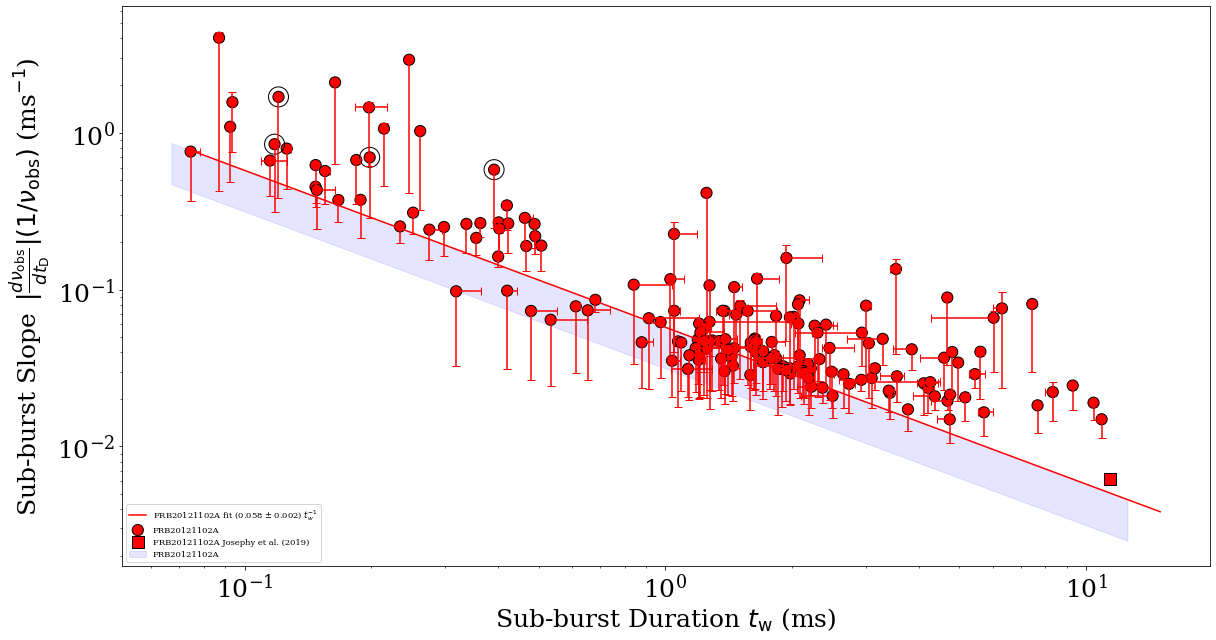

In [321]:
#### TEST For rewrite
from frbrepeaters import driftlaw
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
import warnings, importlib
import scipy
warnings.filterwarnings('ignore')
importlib.reload(driftlaw)

pd.options.mode.chained_assignment = None  # default='warn'
pd.set_option('display.max_rows', None)
%matplotlib inline

chanspaces = [True, True, True, True, True, False, False, False]
chanspaces = [False, False, False, False, False, False, False]
sources_filenames = [ # Analytical measurements
    "results/FRB121102_michilli_924rows_Jul07.csv",
    'results/FRB121102_oostrum_1025rows_Jul07.csv', 
    'results/FRB121102_aggarwal_4785rows_Jul07.csv',
    'results/GajjarFRB121102_672rows_Jul07.csv', 
    'results/FRB121102_Li_419rows_Jul07.csv',
    'results/FRB121102_Li_waittimes_1758rows_Jul07.csv'
]

sources = []

print("Loading...")
for sfile, chanspace in zip(sources_filenames, chanspaces):
    df = pd.read_csv(sfile)
    df = df.set_index("name")
    print(sfile)
    df = driftlaw.computeModelDetails(df, channelSpaceDuration=chanspace)
    sources.append(df)

names = [
    'FRB20121102A Michilli et al. (2018)', 
    'FRB20121102A Oostrum et al. (2020)',
    'FRB20121102A Aggarwal et al. (2021)',
    'FRB20121102A Gajjar et al. (2018)',
    'FRB20121102A Li et al. (2021)',
    'FRB20121102A Li_waits et al. (2021)',
]
annotations = [
    [0, 1, 2, 3, 4, 5],
    [],
    [],
    [],
    [],
    [],
    # []
]
dmlimited = [
    ['M003', 'M005', 'M006', 'M014'],
    [],
    [],
    [],
    [],
    [],
]
exclusions = [
    ['M009', 'M010', 'M013'],
    ['R1_B10'], # ['R1_B08', 'R1_B09', R1_B10', 'R1_B12']
    ['B016', 'B028', 'B056', 'B109', 'B076', 'B079', 'B082', 'B133', 'B093', 'B091', 'B121', 'B128', 'B005', 'B008', 'B020', 'B022', 'B024', 'B029', 'B032', 'B032_b', 'B033', 'B038', 'B039', 'B041', 'B045', 'B048', 'B048_a', 'B048_b', 'B051', 'B055', 'B060', 'B060_a', 'B060_b', 'B064', 'B068', 'B069', 'B070', 'B071', 'B077', 'B078', 'B083', 'B086', 'B088_a', 'B088_b', 'B097', 'B099', 'B103', 'B107', 'B115', 'B127', 'B131'],
    ['11A', '11B', '12A', '12B', '11G'],
    [],
    [
        'FRB121102_tracking-M01_0576',
        'FRB121102_tracking-M01_1180',#
        'FRB121102_tracking-M01_0055',
        'FRB121102_tracking-M01_0095',
        'FRB121102_tracking-M01_0163',
        'FRB121102_tracking-M01_0264',
        'FRB121102_tracking-M01_0388',
        'FRB121102_tracking-M01_0415',
        'FRB121102_tracking-M01_0487',
        'FRB121102_tracking-M01_0576',
        'FRB121102_tracking-M01_0634'
    ]
]


targetDMs = [558.816263157895, 555.0, 555.0, 555.0]
targetDMs = [557.048789473684, 563.5, 559.5, 555.0]
targetDMs = [557.637947368421, 563.5, 559.5, 556.0, 563.5]
targetDMs = [557.637947368421, 560, 559.5, 556.0, 563.5]
targetDMs = [557.637947368421, 563.5, 559.5, 556.0, 560.5]
targetDMs = [557.637947368421, 563.5, 559.5, 556.0, 561.5, 561.5]
targetDMs = [558.5, 563.5, 559.5, 556.0, 561.5, 561.5]
targetDMs = [558.0, 563.5, 559.5, 556.0, 561.5, 561.5]
targetDMs = [558.0, 563.5, 559.5, 556.0, 561.5, 562.0]
targetDMs = [558.0, 561.0, 559.5, 556.0, 561.5, 562.0]

def getFRB20121102AFit(pltdata):
    """ merge michilli and gajjar and fit together"""
    frb121102frame = pd.concat([pltdata['frames'][0],pltdata['frames'][1]])
    _, fits = driftlaw.plotSlopeVsDuration([frb121102frame], ['merged'], logscale=True, fiterrorfunc=driftlaw.log_error)
    return fits[0][1], fits[0][2]

allsources = pd.concat(sources)
allexclusions = []
for excl in exclusions:
    for e in excl:
        allexclusions.append(e)
bakeddata, fitdata, sources, extradata = driftlaw.bakeMeasurements([allsources], ['FRB20121102A'], [allexclusions], [560.0], logging=False, tagColors=['r', 'b', 'g', 'y', 'c'])
Bconstants = extradata['Bconstants']

# bakeddata['frames'][0] = pd.concat([bakeddata['frames'][0], bakeddata['frames'][1]])
# del bakeddata['frames'][1]
# del bakeddata['labels'][1]
annotatei = [-1]
annotatei = []
ax, _ = driftlaw.plotSlopeVsDuration(bakeddata['frames'], bakeddata['labels'], fitlines=['r-', 'r--', 'b--', 'g-.'], markers=['o', 'd', 'p', 'X'], title=None, 
                                     annotatei=annotatei, fitextents=[0.0728, 15], hidefit=[],
                                     logscale=True, errorfunc=driftlaw.limitedDMrangeerror, fiterrorfunc=driftlaw.log_error)

## Mark all bursts whose DM ranges were limited by the exclusion process
for i, limitedpoints in enumerate(dmlimited):
    for lp in limitedpoints:
        # print('YOO: ', i, limitedpoints, lp)
        # print(bakeddata['frames'][i].head())
        v = bakeddata['frames'][i].loc[lp]
        plt.scatter(v['tau_w_ms'], v['slope_over_nuobs'], facecolors='none', edgecolors='k', linewidth=1.0, s=400)
        # ax.annotate('o', (v['tau_w_ms'], v['slope_over_nuobs']), xytext=(-10,-18), textcoords='offset pixels', weight='bold', size=25)

# see Josephy et al. 2019, manually add this point        
C1data = ['C1', 1.9077, 184, 63, -3.92, 0.01, 630, 0.003, 3, 11.4, 11.4/1000, 0.12, 1]
josephyburst = pd.DataFrame([C1data], columns=['name', 'angle', 'sigmax', 'sigmay', 'slope (mhz/ms)', 'slope error (mhz/ms)', 'center_f', 'time_res', 'freq_res', 'tau_w_ms', 'tau_w', 'tau_w_error', 'red_chisq']).set_index('name')
josephyburst['slope_over_nuobs'] = -1*josephyburst['slope (mhz/ms)']/josephyburst['center_f']
xerr, yerr = driftlaw.modelerror(josephyburst)
ax.scatter(josephyburst['tau_w_ms'], josephyburst['slope_over_nuobs'], c='r', s=125, edgecolors='k', marker='s', label='FRB20121102A Josephy et al. (2019)')
ax.errorbar(josephyburst['tau_w_ms'], josephyburst['slope_over_nuobs'], xerr=xerr[0], yerr=yerr[0], ecolor='r')

# Plot shaded regions
alldata = pd.concat([f for f in bakeddata['frames']+[josephyburst]])
x = np.linspace(min(alldata['tau_w_ms'])*0.9, max(alldata['tau_w_ms'])*1.1, num=1200)
# plt.rcParams['hatch.linewidth'] = 1
for name, color, hatch in zip(fitdata.name.unique(), bakeddata['colors'], ['', '/', '\\', '-', '', '', '', '']):
    # params = fitdata.loc[(fitdata.name == name) & (fitdata.numbursts > 1.0)]['param'] # full range
    fitdf = fitdata.loc[(fitdata.name == name)]
    params = fitdf.loc[(fitdf.numbursts == fitdf.numbursts.max())]['param'] # only fits with max numbursts
    print(f"{name} ({min(params):.3f} - {max(params):.3f}) $t_w^{{-1}}$")
    if True or 'Michilli' not in name: # michilli region is contained in gajjar region so no need to plot it
        lstr = f"{name.split(' ')[0]} range of fits"
        lstr = name
        ax.fill_between(x, min(params)/x, max(params)/x, alpha=0.1, color=color, edgecolor=color, label=lstr, zorder=-10)
        # ax.fill_between(x, min(params)/x, max(params)/x, alpha=0.1, color='None', edgecolor='w', hatch=hatch, zorder=-9)

## Combine michilli and gajjar fits. See `getFRB20121102AFit()`. the result of the fit when merging frames is 0.083 +- 0.005
# frb121102_A = getFRB20121102AFit(bakeddata) # opens a figure
# frb121102_A = (0.07816130353202802, 0.005971946986254264)
# plt.plot(x, frb121102_A[0]/x, 'r-', label='{} fit ({:.3f} $\\pm$ {:.3f}) $t_w^{{-1}}$'.format('FRB20121102A', frb121102_A[0], frb121102_A[1]))

# Legend stuff
hdls, lbls = ax.get_legend_handles_labels()
# order = [3, 4, 7, 5, 6, 2, 0, 1, 8, 9, 10]
# ax.legend([hdls[idx] for idx in order], [lbls[idx] for idx in order], fontsize='x-large')
# hdls[0], hdls[1], hdls[2], hdls[5], hdls[6], hdls[7] = hdls[2], hdls[0], hdls[1], hdls[7], hdls[5], hdls[6]
# lbls[0], lbls[1], lbls[2], lbls[5], lbls[6], lbls[7] = lbls[2], lbls[0], lbls[1], lbls[7], lbls[5], lbls[6]
ax.legend(fontsize='small', loc=3)
# ax.legend(hdls[7:18], lbls[7:18], fontsize='medium')
# ax.get_legend().remove()

# ax.set_xlim(0.0737, 12.5)
# ax.set_ylim(0.0013395279509532563, 508.64764364084175)
# plt.savefig('figures/driftvnuobs_dmvars.pdf')
print(f"target DMs: {driftlaw.getOptimalDMs(fitdata, log=False)}")

## Superradiance

Loading...
results/frb121102_michilli_dmvariations.csv
results/FRB121102_oostrum_984rows_Mar01.csv
results/FRB121102_aggarwal_2145rows_Feb28.csv
results/GajjarFRB121102_results_506rows_Jan22.csv
results/simulated/wfall_1420_apr12.csv
results/simulated/wfall_1612_apr12.csv
results/simulated/wfall_4660_apr12.csv

# FRB20121102A Michilli et al. (2018):
>> DM range after maximizing bursts: 554.103 - 561.172894736842 pc/cm3
>> num bursts remaining = 14

# FRB20121102A Oostrum et al. (2020):
>> DM range after maximizing bursts: 555.0 - 564.0 pc/cm3
>> num bursts remaining = 20

# FRB20121102A Aggarwal et al. (2021):
>> DM range after maximizing bursts: 555.0 - 560.5 pc/cm3
>> num bursts remaining = 40

# FRB20121102A Gajjar et al. (2018):
>> DM range after maximizing bursts: 555.0 - 563.0 pc/cm3
>> num bursts remaining = 20

# Simulated 1420 Bursts:
>> DM range after maximizing bursts: -2.0 - 1.11111111111111 pc/cm3
>> num bursts remaining = 4

# Simulated 1612 Bursts:
>> DM range after maxi

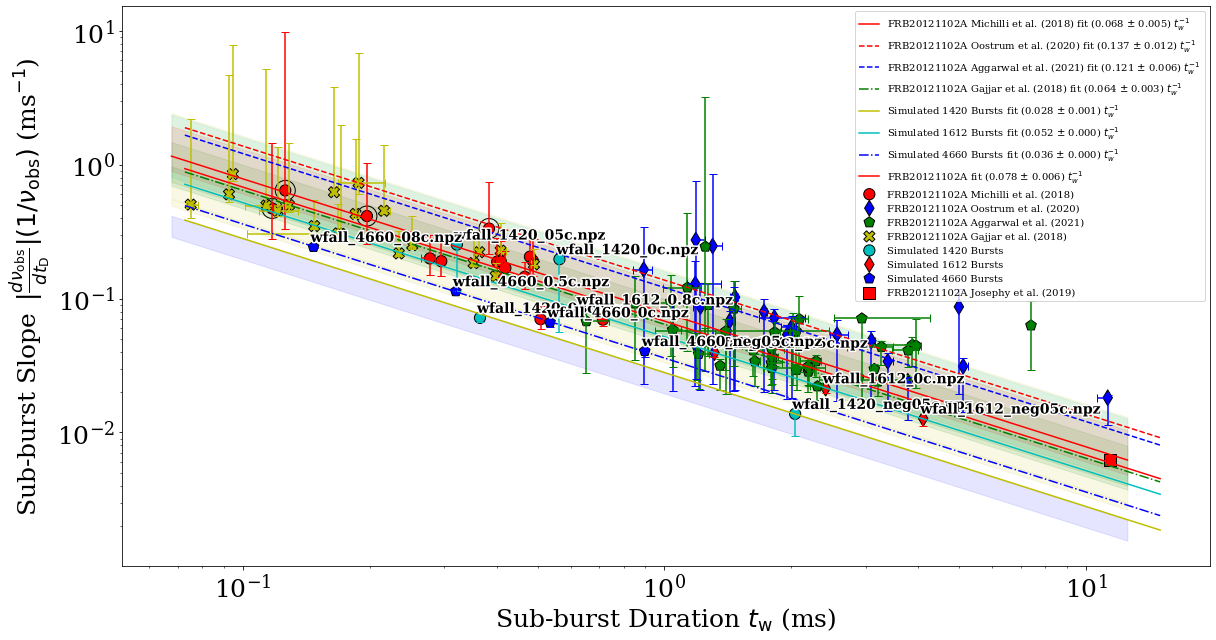

In [14]:
### SUPERRADIANCE PULSES
from frbrepeaters import driftlaw
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
import warnings, importlib
import scipy
warnings.filterwarnings('ignore')
importlib.reload(driftlaw)

pd.options.mode.chained_assignment = None  # default='warn'
pd.set_option('display.max_rows', None)
%matplotlib inline

chanspaces = [True, False, False, False, False, False, False]
sources_filenames = [
    "results/frb121102_michilli_dmvariations.csv",
    'results/FRB121102_oostrum_984rows_Mar01.csv',
    'results/FRB121102_aggarwal_2145rows_Feb28.csv',
    'results/GajjarFRB121102_results_506rows_Jan22.csv',
    # 'results/FRB121102_Li_419rows_Mar31.csv',
    # 'results/FRB121102_Li_waittimes_1592rows_Apr08.csv',
    # 'results/simulated/multiplelines_aish_apr10.csv'
    'results/simulated/wfall_1420_apr12.csv',
    'results/simulated/wfall_1612_apr12.csv',
    'results/simulated/wfall_4660_apr12.csv'
]

sources = []

print("Loading...")
for sfile, chanspace in zip(sources_filenames, chanspaces):
    df = pd.read_csv(sfile)
    df = df.set_index("name")
    print(sfile)
    df = driftlaw.computeModelDetails(df, channelSpaceDuration=chanspace)
    sources.append(df)

names = [
    'FRB20121102A Michilli et al. (2018)', 
    'FRB20121102A Oostrum et al. (2020)',
    'FRB20121102A Aggarwal et al. (2021)',
    'FRB20121102A Gajjar et al. (2018)',
    # 'FRB20121102A Li et al. (2021)',
    # 'FRB20121102A Li_waits et al. (2021)',
    'Simulated 1420 Bursts',
    'Simulated 1612 Bursts',
    'Simulated 4660 Bursts'
]
annotations = [
    [0, 1, 2, 3, 4, 5],
    [],
    [],
    [],
    [],
    [],
    []
]
dmlimited = [
    [3, 5, 6, 14],
    [],
    [],
    [],
    [],
    [],
    []
]
exclusions = [
    [],
    ['R1_B08', 'R1_B09', 'R1_B10', 'R1_B12'],
    ['B023', 'B016', 'B028', 'B056', 'B109', 'B076', 'B079', 'B093', 'B091', 'B121', 'B128'],
    ['11A', '11B', '12A'],
    [],
    [],
    []
]

targetDMs = [557.637947368421, 563.5, 559.5, 556.0, 1.1111111111111107, 1.1111111111111107, 1.1111111111111107]
targetDMs = [557.637947368421, 563.5, 559.5, 556.0, 1.11111111111111, -0.666666666666667, 0.666666666666667]

def getFRB20121102AFit(pltdata):
    """ merge michilli and gajjar and fit together"""
    frb121102frame = pd.concat([pltdata['frames'][0],pltdata['frames'][1]])
    _, fits = driftlaw.plotSlopeVsDuration([frb121102frame], ['merged'], logscale=True, fiterrorfunc=driftlaw.log_error)
    return fits[0][1], fits[0][2]

bakeddata, fitdata, sources, extradata = driftlaw.bakeMeasurements(sources, names, exclusions, targetDMs, logging=False, tagColors=['r', 'b', 'g', 'y', 'c'])
Bconstants = extradata['Bconstants']

# bakeddata['frames'][0] = pd.concat([bakeddata['frames'][0], bakeddata['frames'][1]])
# del bakeddata['frames'][1]
# del bakeddata['labels'][1]
annotatei = [-3, -2, -1]
ax, _ = driftlaw.plotSlopeVsDuration(bakeddata['frames'], bakeddata['labels'], fitlines=['r-', 'r--', 'b--', 'g-.', 'y-', 'c-', 'b-.', 'c--'], markers=['o', 'd', 'p', 'X'], title=None, 
                                     annotatei=annotatei, fitextents=[0.0728, 15], hidefit=[],
                                     logscale=True, errorfunc=driftlaw.limitedDMrangeerror, fiterrorfunc=driftlaw.log_error)

## Mark all bursts whose DM ranges were limited by the exclusion process
for i, limitedpoints in enumerate(dmlimited):
    for lp in limitedpoints:
        # print('YOO: ', i, limitedpoints, lp)
        # print(bakeddata['frames'][i].head())
        v = bakeddata['frames'][i].loc[lp]
        plt.scatter(v['tau_w_ms'], v['slope_over_nuobs'], facecolors='none', edgecolors='k', linewidth=1.0, s=400)
        # ax.annotate('o', (v['tau_w_ms'], v['slope_over_nuobs']), xytext=(-10,-18), textcoords='offset pixels', weight='bold', size=25)

# see Josephy et al. 2019, manually add this point        
C1data = ['C1', 1.9077, 184, 63, -3.92, 0.01, 630, 0.003, 3, 11.4, 11.4/1000, 0.12, 1]
josephyburst = pd.DataFrame([C1data], columns=['name', 'angle', 'sigmax', 'sigmay', 'slope (mhz/ms)', 'slope error (mhz/ms)', 'center_f', 'time_res', 'freq_res', 'tau_w_ms', 'tau_w', 'tau_w_error', 'red_chisq']).set_index('name')
josephyburst['slope_over_nuobs'] = -1*josephyburst['slope (mhz/ms)']/josephyburst['center_f']
xerr, yerr = driftlaw.modelerror(josephyburst)
ax.scatter(josephyburst['tau_w_ms'], josephyburst['slope_over_nuobs'], c='r', s=125, edgecolors='k', marker='s', label='FRB20121102A Josephy et al. (2019)')
ax.errorbar(josephyburst['tau_w_ms'], josephyburst['slope_over_nuobs'], xerr=xerr[0], yerr=yerr[0], ecolor='r')

# Plot shaded regions
alldata = pd.concat([f for f in bakeddata['frames']+[josephyburst]])
x = np.linspace(min(alldata['tau_w_ms'])*0.9, max(alldata['tau_w_ms'])*1.1, num=1200)
# plt.rcParams['hatch.linewidth'] = 1
for name, color, hatch in zip(fitdata.name.unique(), bakeddata['colors'], ['', '/', '\\', '-', '', '', '', '']):
    # params = fitdata.loc[(fitdata.name == name) & (fitdata.numbursts > 1.0)]['param'] # full range
    fitdf = fitdata.loc[(fitdata.name == name)]
    params = fitdf.loc[(fitdf.numbursts == fitdf.numbursts.max())]['param'] # only fits with max numbursts
    print(f"{name} ({min(params):.3f} - {max(params):.3f}) $t_w^{{-1}}$")
    if True or 'Michilli' not in name: # michilli region is contained in gajjar region so no need to plot it
        lstr = f"{name.split(' ')[0]} range of fits"
        lstr = name
        ax.fill_between(x, min(params)/x, max(params)/x, alpha=0.1, color=color, edgecolor=color, label=lstr, zorder=-10)
        # ax.fill_between(x, min(params)/x, max(params)/x, alpha=0.1, color='None', edgecolor='w', hatch=hatch, zorder=-9)

## Combine michilli and gajjar fits. See `getFRB20121102AFit()`. the result of the fit when merging frames is 0.083 +- 0.005
# frb121102_A = getFRB20121102AFit(bakeddata) # opens a figure
frb121102_A = (0.07816130353202802, 0.005971946986254264)
plt.plot(x, frb121102_A[0]/x, 'r-', label='{} fit ({:.3f} $\\pm$ {:.3f}) $t_w^{{-1}}$'.format('FRB20121102A', frb121102_A[0], frb121102_A[1]))

# Legend stuff
hdls, lbls = ax.get_legend_handles_labels()
# order = [3, 4, 7, 5, 6, 2, 0, 1, 8, 9, 10]
# ax.legend([hdls[idx] for idx in order], [lbls[idx] for idx in order], fontsize='x-large')
# hdls[0], hdls[1], hdls[2], hdls[5], hdls[6], hdls[7] = hdls[2], hdls[0], hdls[1], hdls[7], hdls[5], hdls[6]
# lbls[0], lbls[1], lbls[2], lbls[5], lbls[6], lbls[7] = lbls[2], lbls[0], lbls[1], lbls[7], lbls[5], lbls[6]
ax.legend(fontsize='medium')
ax.legend(hdls[0:16], lbls[0:16], fontsize='medium')
# ax.get_legend().remove()

# ax.set_xlim(0.0737, 12.5)
# ax.set_ylim(0.0013395279509532563, 508.64764364084175)
# plt.savefig('figures/driftvnuobs_dmvars.pdf')
print(f"target DMs: {driftlaw.getOptimalDMs(fitdata, log=False)}")

## Multiple Sources

results/frb121102_michilli_dmvariations.csv
results/gajjar11a_dmvariations_oct15_2021.csv
results/dmvars_180916.csv
results/dmvars_180814.csv
results/FRB180301_DM516-518-5_luo_272rows_Aug21.csv
results/FRB121102_oostrum_525rows_Aug28.csv
results/FRB121102_aggarwal_results_1078rows_Dec08.csv
results/GajjarFRB121102_results_506rows_Oct19.csv

# FRB20121102A Michilli et al. (2018):
>> num bursts remaining = 14

# FRB20121102A 11A Gajjar et al. (2018):
>> num bursts remaining = 2

# FRB20180916B bursts:
>> num bursts remaining = 16

# FRB20180814A bursts:
>> num bursts remaining = 6

# FRB20180301A bursts:
>> num bursts remaining = 15

# FRB20121102A Oostrum et al. (2020):
>> num bursts remaining = 23

# FRB20121102A Aggarwal et al. (2021):
>> num bursts remaining = 43

# FRB20121102A Gajjar et al. (2018):
>> num bursts remaining = 21
len(fig1pltdata['frames']) = 8, len(sources) = 8
FRB20121102A Michilli et al. (2018) (0.050 - 0.133) $t_w^{-1}$
FRB20121102A 11A Gajjar et al. (2018) (0.063 

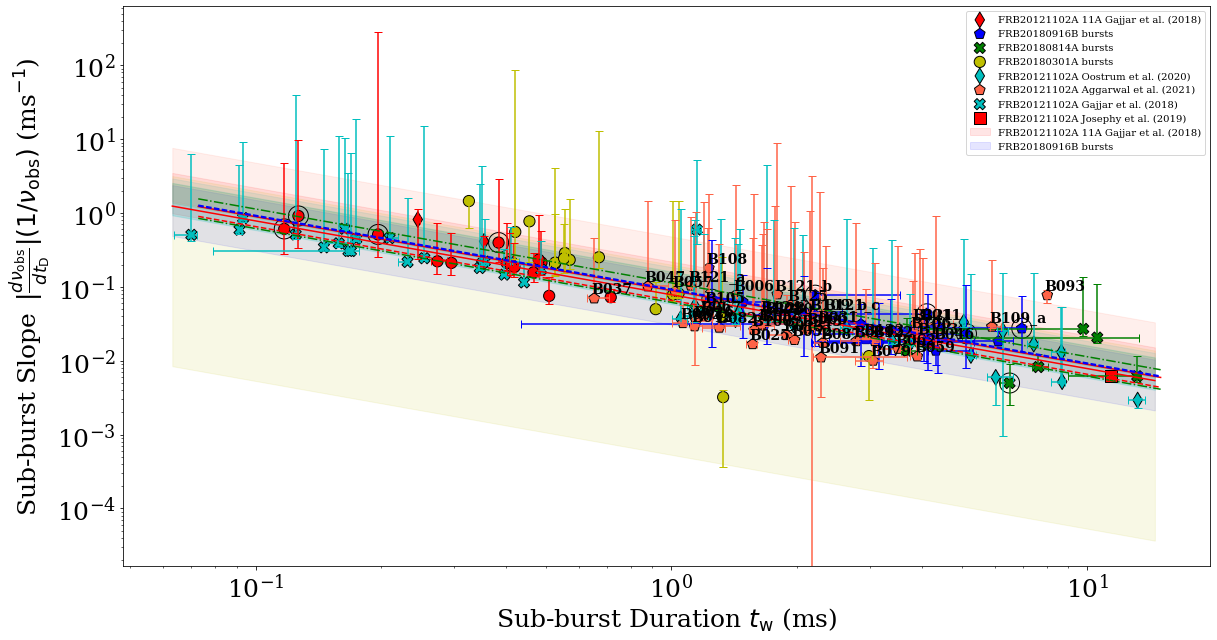

In [44]:
from frbrepeaters import driftlaw
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
import warnings, importlib
import scipy
warnings.filterwarnings('ignore')
importlib.reload(driftlaw)

pd.options.mode.chained_assignment = None  # default='warn'
pd.set_option('display.max_rows', None)
%matplotlib inline

sources_filenames = [
    "results/frb121102_michilli_dmvariations.csv",
    'results/gajjar11a_dmvariations_oct15_2021.csv',
    'results/dmvars_180916.csv',
    'results/dmvars_180814.csv',
    'results/FRB180301_DM516-518-5_luo_272rows_Aug21.csv',
    'results/FRB121102_oostrum_525rows_Aug28.csv',
    'results/FRB121102_aggarwal_results_1078rows_Dec08.csv',
    'results/GajjarFRB121102_results_506rows_Oct19.csv',
    # 'results/simulated_nov15.csv'
]

data_sources_filenames = [
    "results/frb121102_michilli_dmvariations.csv",
    'results/gajjar11a_dmvariations_oct15_2021.csv',
    'results/dmvars_180916.csv',
    'results/dmvars_180814.csv',
    'results/FRB180301_DM516-518-5_luo_272rows_Aug21.csv',
    'results/FRB121102_oostrum_results_504rows_Jan19.csv',
    'results/FRB121102_aggarwal_results_1122rows_Jan14.csv',
    'results/GajjarFRB121102_results_506rows_Jan22.csv',
]

sources = []
for sfile in sources_filenames:
    df = pd.read_csv(sfile)
    df = df.set_index("name")
    print(sfile)
    df = driftlaw.computeModelDetails(df, channelSpaceDuration=True)
    sources.append(df)

names = [
    'FRB20121102A Michilli et al. (2018) DM Variations', 
    'FRB20121102A 11A Gajjar et al. (2018) DM Variations', 
    'FRB20180916B bursts DM Variations', 
    'FRB20180814A bursts DM Variations',
    'FRB20180301A bursts DM Variations',
    'FRB20121102A Oostrum et al. (2020) DM Variations',
    'FRB20121102A Aggarwal et al. (2021) DM Variations',
    'FRB20121102A Gajjar et al. (2018) DM Variations',
    # 'Simulated DM Variations'
]
annotations = [
    [0, 1, 2, 3, 4, 5],
    [],
    [3],
    [0, 1, 2, 3, 4, 5],
    [0, 1, 2, 3, 4, 5],
    [],
    # [],
    [],
    []
]
dmlimited = [
    [3, 5, 6, 14],
    [],
    [15.5, 16, 23, 24, 29, 31, 32, 33],
    [180919.0],
    [],
    [],
    [],
    [],
    []
]
exclusions = [
    [],
    [],
    [],
    [180917.0], # first is a multi burst, second has negative drift (which should better be corrected by limiting 180814's DM range)
    [],
    [],
    ['B023', 'B016', 'B028', 'B056', 'B109'],
    [],
    []
]

targetDMs   = [
    558.816263157895, 
    568.333333333333, 
    348.82, 
    188.8, 
    516.3571428571429, 
    560.526315789474,
    560,
    556,
    565
] 

def exclusionLogger(exclusionstr, frame):
    return # short 
    print(exclusionstr)
    count = 0
    if frame.empty:
        print(">> bursts excluded: \n\tnone")
    else:
        print('>> bursts excluded:', *[f"\n\t{exname} DM = {row['DM']}" for exname, row in frame.iterrows()])
        count += len(frame)
    print(f'>> # of measurements excluded: {count}')
    print(f'>> # of bursts limited: {len(frame.index.unique())}')
    return count

def DMrangeLogger(sname, frame, burstwise=False):
    return # short 
    if not burstwise:
        if type(frame) == pd.core.series.Series:
            print(f"{sname}\tDM Range: {frame[0]} pc/cm3")
        else:
            print(f"{sname}\t DM Range: {min(frame['DM'])} - {max(frame['DM'])} pc/cm3")
    else:
        print(f'>>> {sname} DM Range by burst:')
        for bname in frame.index.unique():
            DMrangeLogger(f'\tburst {bname}:', frame.loc[bname])
    return

def getFRB20121102AFit(pltdata):
    """ merge michilli and gajjar and fit together"""
    frb121102frame = pd.concat([pltdata['frames'][0],pltdata['frames'][1]])
    _, fits = driftlaw.plotSlopeVsDuration([frb121102frame], ['merged'], logscale=True, fiterrorfunc=driftlaw.log_error)
    return fits[0][1], fits[0][2]

fig1pltdata = { 'frames': [], 'labels': [], 'colors': cycle(['r', 'r', 'b', 'g', 'y', 'c', 'tomato', 'c']) }
fitdata = pd.DataFrame()
Bconstants = []
for source, name, annotate, exclude, targetDM in zip(sources, names, annotations, exclusions, targetDMs):
    frames = []
    labels = []
    
    print('\n#', name.split(' DM')[0]+':')
    DMrangeLogger('', source)
    source = source.drop(exclude)

    ## Burst Exclusions
    # exclude bursts that where a fit was not found
    exclusionLogger('> exclusion rule: no fit found', source[~(source.amplitude > 0)])
    source = source[source.amplitude > 0]
       
    # exclude positive drifts, we assume they are non-physical and an artifact of over dedispersion
    exclusionLogger('> exclusion rule: slope_abs < 0', source[~(source.slope_abs > 0)])
    source = source[source.slope_abs > 0] 

    # exclude slopes with large relative errors
    relerrthreshold = 0.4 # (40%)
    exclusionLogger(f'> exclusion rule: rel slope error > {relerrthreshold}', source[~(abs(source['slope error (mhz/ms)']/source['slope (mhz/ms)']) < relerrthreshold)])
    source = source[abs(source['slope error (mhz/ms)']/source['slope (mhz/ms)']) < relerrthreshold]
    
    # exclude slopes with huge errors, they are vertical and poorly measured
    errorthreshold = 1e8
    exclusionLogger('> exclusion rule: slope error > {}'.format(errorthreshold), source[~(source['slope error (mhz/ms)'] < errorthreshold)])
    source = source[source['slope error (mhz/ms)'] < errorthreshold] 
    
    DMrangeLogger(name.split(' DM')[0], source, burstwise=True) # log the dm range after we're done excluding
    source = driftlaw.sloperanges(source) # compute drift ranges after burst exclusions

    # special case: exclude 180911 at 190 pc/cm3 cuz drift range switches sign
    # TODO remove in favor of relative error (see above)
    # or exclude if 'slope_nu_minus' is negative but the other way seems more flexible
    if name == names[3]:
        source = source[~((source.DM == 190) & (source.slope_nu_min < 0))]
    source = driftlaw.sloperanges(source) # recompute range 

    for dm, color in zip(source.DM.unique(), cycle(['r', 'y', 'b', 'k', 'g', 'c', 'm'])):
        df = source[source.DM == dm]
        df['color'] = color
        frames.append(df)
        labels.append(dm)
        
        # Figure 1
        if np.isclose(dm, targetDM):
            print(f'>> num bursts remaining = {len(df.index.unique())}')
            df['color'] = next(fig1pltdata['colors'])
            fig1pltdata['frames'].append(df)
            fig1pltdata['labels'].append(name.split(' DM')[0])
                        
        # For Ref figure A, turn off otherwise
        # if dm == 565:
        #     df['color'] = 'b'
        # if dm == 348.82:
        #     df['color'] = 'r'
            
        # Figure 5: compute drift/nu^2 vs nu range of fits
        nus = np.linspace(0, 20000, num=2000)   
        popt, pcov = scipy.optimize.curve_fit(lambda x, c: c, nus, df['slope_abs_nuobssq'])
        Bconstants.append((popt[0], np.sqrt(pcov[0])))
        
    # driftlaw.plotSlopeVsDuration(frames, labels, title=name, annotatei=annotate, logscale=True)
    markcolors = []
    for f in frames: 
        markcolors.append(f['color'].iloc[0])
    markcolors = cycle(markcolors)
    # manylines = ['r--', 'y-', 'b-.', 'k--', 'g--', 'c-.', 'r-', 'b-', 'k-', 'g-', 'c-']
    linestyles = ['--', '-', '-.', '--', '--', '-.', '-', '-', '-', '-', '-']
    manylines = [next(markcolors)+lst for lst in linestyles]
    labels = [round(lbl, 2) for lbl in labels]
    tempax, fits = driftlaw.plotSlopeVsDuration(frames, labels, annotatei=[], fitlines=manylines, logscale=True, fiterrorfunc=driftlaw.log_error, dmtrace=True, hidefitlabel=True)
    if name.split(' DM')[0] == 'FRB20180916B bursts':
        hdls, lbls = tempax.get_legend_handles_labels()
        order = [2, 1, 0, 3, 4]
        tempax.legend([hdls[idx] for idx in order], [lbls[idx] for idx in order], fontsize='x-large')
    if name.split(' DM')[0] == 'FRB20121102A Gajjar et al. (2018)':
        tempax.set_xlim(0.073, 0.389)
        tempax.legend(fontsize='x-large', loc=1)
    
    for fit in fits:
        fitdata = fitdata.append({'name': name.split(' DM')[0], 
                                  'DM': fit[0], 
                                  'param': fit[1], 
                                  'err': fit[2] ,
                                  'red_chisq': fit[3], 
                                  'numbursts': fit[5]},
                                  ignore_index=True)

plt.close('all')

# fig1pltdata['frames'][0] = pd.concat([fig1pltdata['frames'][0], fig1pltdata['frames'][1]])
# del fig1pltdata['frames'][1]
# del fig1pltdata['labels'][1]
annotatei = [6]
ax, _ = driftlaw.plotSlopeVsDuration(fig1pltdata['frames'], fig1pltdata['labels'], fitlines=['r-', 'r--', 'b--', 'g-.'], markers=['o', 'd', 'p', 'X'], title=None, 
                                     annotatei=annotatei, fitextents=[0.0728, 15], hidefit=[0, 1],
                                     logscale=True, errorfunc=driftlaw.rangeerror, fiterrorfunc=driftlaw.log_error)

## Mark all bursts whose DM ranges were limited by the exclusion process
print(f"{len(fig1pltdata['frames']) = }, {len(sources) = }")
for i, limitedpoints in enumerate(dmlimited):
    for lp in limitedpoints:
        # print('YOO: ', i, limitedpoints, lp)
        # print(fig1pltdata['frames'][i].head())
        v = fig1pltdata['frames'][i].loc[lp]
        plt.scatter(v['tau_w_ms'], v['slope_over_nuobs'], facecolors='none', edgecolors='k', linewidth=1.0, s=400)
        # ax.annotate('o', (v['tau_w_ms'], v['slope_over_nuobs']), xytext=(-10,-18), textcoords='offset pixels', weight='bold', size=25)

# see Josephy et al. 2019, manually add this point        
C1data = ['C1', 1.9077, 184, 63, -3.92, 0.01, 630, 0.003, 3, 11.4, 11.4/1000, 0.12, 1]
josephyburst = pd.DataFrame([C1data], columns=['name', 'angle', 'sigmax', 'sigmay', 'slope (mhz/ms)', 'slope error (mhz/ms)', 'center_f', 'time_res', 'freq_res', 'tau_w_ms', 'tau_w', 'tau_w_error', 'red_chisq']).set_index('name')
josephyburst['slope_over_nuobs'] = -1*josephyburst['slope (mhz/ms)']/josephyburst['center_f']
xerr, yerr = driftlaw.modelerror(josephyburst)
ax.scatter(josephyburst['tau_w_ms'], josephyburst['slope_over_nuobs'], c='r', s=125, edgecolors='k', marker='s', label='FRB20121102A Josephy et al. (2019)')
ax.errorbar(josephyburst['tau_w_ms'], josephyburst['slope_over_nuobs'], xerr=xerr[0], yerr=yerr[0], ecolor='r')

# Plot shaded regions
alldata = pd.concat([f for f in fig1pltdata['frames']+[josephyburst]])
x = np.linspace(min(alldata['tau_w_ms'])*0.9, max(alldata['tau_w_ms'])*1.1, num=1200)
# plt.rcParams['hatch.linewidth'] = 1
for name, color, hatch in zip(fitdata.name.unique(), fig1pltdata['colors'], ['', '/', '\\', '-', '', '', '', '']):
    params = fitdata.loc[(fitdata.name == name) & (fitdata.numbursts > 1.0)]['param']
    print(f"{name} ({min(params):.3f} - {max(params):.3f}) $t_w^{{-1}}$")
    if 'Michilli' not in name: # michilli region is contained in gajjar region so no need to plot it
        lstr = f"{name.split(' ')[0]} range of fits"
        lstr = name
        ax.fill_between(x, min(params)/x, max(params)/x, alpha=0.1, color=color, edgecolor=color, label=lstr, zorder=-10)
        # ax.fill_between(x, min(params)/x, max(params)/x, alpha=0.1, color='None', edgecolor='w', hatch=hatch, zorder=-9)

## Combine michilli and gajjar fits. See `getFRB20121102AFit()`. the result of the fit when merging frames is 0.083 +- 0.005
# frb121102_A = getFRB20121102AFit(fig1pltdata) # opens a figure
frb121102_A = (0.07816130353202802, 0.005971946986254264)
plt.plot(x, frb121102_A[0]/x, 'r-', label='{} fit ({:.3f} $\\pm$ {:.3f}) $t_w^{{-1}}$'.format('FRB20121102A', frb121102_A[0], frb121102_A[1]))

# Legend stuff
hdls, lbls = ax.get_legend_handles_labels()
# order = [3, 4, 7, 5, 6, 2, 0, 1, 8, 9, 10]
# ax.legend([hdls[idx] for idx in order], [lbls[idx] for idx in order], fontsize='x-large')
# hdls[0], hdls[1], hdls[2], hdls[5], hdls[6], hdls[7] = hdls[2], hdls[0], hdls[1], hdls[7], hdls[5], hdls[6]
# lbls[0], lbls[1], lbls[2], lbls[5], lbls[6], lbls[7] = lbls[2], lbls[0], lbls[1], lbls[7], lbls[5], lbls[6]
# ax.legend(fontsize='medium')
ax.legend(hdls[8:18], lbls[8:18], fontsize='medium')
# ax.get_legend().remove()

# ax.set_xlim(0.0737, 12.5)
# ax.set_ylim(0.0013395279509532563, 508.64764364084175)
# plt.savefig('figures/driftvnuobs_dmvars.pdf')

# Burst Metadata

Total number of bursts: 168
FRB20121102A Michilli et al. (2018)   : 19 bursts, 4242 - 4688 MHz, 4242 - 4688 (new) MHz, tw: 0.09 - 0.68 ms tw_FWHM_ms: 0.14 - 1.12 ms


,center_f,center_f_new,tau_w_ms,tw_FWHM_ms,band_FWHM_mhz
name,,,,,
M001,4436.468057,4436.468057,0.488876,0.810967,384.489312
M002,4397.572206,4397.572206,0.466462,0.774763,353.553391
M003,4506.109189,4506.109189,0.197989,0.325835,366.811643
M004,4541.917444,4541.917444,0.280993,0.463410,300.520382
M005,4410.865109,4410.865109,0.387739,0.651670,397.747564
M006,4462.307604,4462.307604,0.118932,0.195501,344.714556
M007,4306.557917,4306.557917,0.396156,0.651670,243.067956
M008,4595.804786,4595.804786,0.679075,1.122320,296.100965
M009_a,4459.089062,4459.089062,0.186119,0.289631,212.132034


FRB20121102A Gajjar et al. (2018)     : 21 bursts, 6145 - 7144 MHz, nan - nan (new) MHz, tw: 0.07 - 0.49 ms tw_FWHM_ms: nan - nan ms


,center_f,center_f_new,tau_w_ms,tw_FWHM_ms,band_FWHM_mhz
name,,,,,
11A_a,6927.814215,NaN,0.163418,NaN,NaN
11A_b,6956.342536,NaN,0.093130,NaN,NaN
11A_c,6487.130571,NaN,0.127237,NaN,NaN
11A_d,6144.639514,NaN,0.250768,NaN,NaN
11C,6765.798565,NaN,0.216490,NaN,NaN
11D,6966.133779,NaN,0.363455,NaN,NaN
11E,6689.621165,NaN,0.399805,NaN,NaN
11F,6855.057760,NaN,0.490649,NaN,NaN
11H,7144.183559,NaN,0.147383,NaN,NaN


FRB20121102A Oostrum et al. (2020)    : 23 bursts, 1319 - 1387 MHz, 1319 - 1387 (new) MHz, tw: 0.90 - 11.17 ms tw_FWHM_ms: 1.39 - 18.54 ms


,center_f,center_f_new,tau_w_ms,tw_FWHM_ms,band_FWHM_mhz
name,,,,,
R1_B01,1337.481792,1337.481792,1.191095,1.853638,116.009706
R1_B02,1338.163956,1338.163956,1.202181,1.853638,97.227182
R1_B03,1336.232353,1336.232353,1.457906,2.317048,117.114561
R1_B06,1334.383612,1334.383612,1.166173,1.853638,125.953395
R1_B07,1349.225351,1349.225351,3.771624,6.256028,113.799998
R1_B08,1351.590914,1351.590914,7.676760,12.512057,134.792230
R1_B12,1360.296025,1360.296025,5.756926,9.731600,119.324269
R1_B13,1325.545879,1325.545879,2.505172,4.170686,119.324269
R1_B14,1334.725513,1334.725513,11.167714,18.536380,127.058250


FRB20121102A Aggarwal et al. (2021)   : 63 bursts, 1222 - 1600 MHz, 1222 - 1600 (new) MHz, tw: 0.65 - 10.35 ms tw_FWHM_ms: 1.16 - 17.16 ms


,center_f,center_f_new,tau_w_ms,tw_FWHM_ms,band_FWHM_mhz
name,,,,,
B001,1513.558699,1513.558699,1.744555,3.013898,159.099026
B003,1354.591260,1354.591260,5.529851,9.157612,212.132034
B003_a,1395.009352,1395.009352,2.149944,3.593493,123.743687
B003_b,1326.224119,1326.224119,4.131037,6.839230,176.776695
B004,1454.981422,1454.981422,1.444905,2.318383,123.743687
B006,1407.081591,1407.081591,1.460505,2.434302,203.293200
B011,1456.888173,1456.888173,1.134073,1.738787,114.904852
B013,1503.646166,1503.646166,2.195063,3.593493,106.066017
B023,1470.069341,1470.069341,1.130151,1.854706,61.871843


FRB20121102A Li et al. (2021)         : 42 bursts, 1128 - 1423 MHz, 1128 - 1423 (new) MHz, tw: 0.31 - 9.30 ms tw_FWHM_ms: 0.56 - 15.43 ms


,center_f,center_f_new,tau_w_ms,tw_FWHM_ms,band_FWHM_mhz
name,,,,,
FRB121102_tracking-M01_0112,1259.075365,1259.075365,1.711837,2.849968,96.674755
FRB121102_tracking-M01_0118,1268.654547,1268.654547,2.777373,4.587754,88.388348
FRB121102_tracking-M01_0437,1307.994891,1307.994891,4.751190,7.924302,100.817959
FRB121102_tracking-M01_0448,1348.934409,1348.934409,1.289592,2.154854,140.868929
FRB121102_tracking-M01_0533,1275.273941,1275.273941,1.892111,3.197526,146.393201
FRB121102_tracking-M01_0754,1287.421207,1287.421207,1.590482,2.641434,82.864076
FRB121102_tracking_3-M01_0034,1268.504812,1268.504812,1.353957,2.293877,212.684462
FRB121102_tracking_3-M01_0111,1270.308816,1270.308816,2.145171,3.614594,93.912619
FRB121102_tracking_3-M01_0167,1288.267499,1288.267499,1.980549,3.267037,117.390774


,DM,center_f,slope (mhz/ms),slope error (mhz/ms),theta,red_chisq,amplitude,xo,yo,sigmax,...,lim_slope_min,lim_tw_max,lim_tw_min,lim_band_max,lim_band_min,color,regstart_c,regend_c,regstart_d,regend_d
name,,,,,,,,,,,,,,,,,,,,,
11A_c,557.5,6487.130571,-3599.183386,8.125781,-1.570518,0.187589,2.345465,0.061577,-5.440288,0.127237,...,2833.292169,0.128843,0.125705,1123.963610,1093.091310,#67618C,3.384,4.099,4.099,5.732907
11E,557.5,6689.621165,-993.362896,0.417453,-1.569790,11.684526,0.750331,0.061070,10.302570,0.399804,...,928.431955,0.401029,0.395027,2321.176081,2312.381520,#67618C,NaN,NaN,NaN,NaN
11J,557.5,6719.074038,-2112.764894,8.358339,-1.570323,4.338812,0.252238,0.059705,4.998135,0.162144,...,1808.995649,0.168507,0.162080,1354.646144,1283.864629,#67618C,NaN,NaN,NaN,NaN
11M,557.5,6728.375961,-6093.652169,190.324901,-1.570632,2.256181,0.027873,0.114288,-13.263342,0.193980,...,4099.910440,0.217474,0.168296,1746.043833,1641.283550,#67618C,NaN,NaN,NaN,NaN
11O,557.5,6568.722371,-1394.388398,2.889952,-1.570079,5.020920,0.397581,0.061207,7.192218,0.239459,...,1302.071360,0.239513,0.229394,1327.582752,1301.154453,#67618C,NaN,NaN,NaN,NaN
11Q,557.5,6483.352496,-4613.011519,5.117499,-1.570580,4.720472,7.996342,0.030885,-0.518927,0.092313,...,3164.355488,0.093480,0.092168,1011.890218,984.425771,#67618C,NaN,NaN,NaN,NaN
12B_b,557.5,6599.120854,-2860.456999,6.277436,-1.570447,0.295363,1.965072,0.092274,-9.511103,0.154841,...,2233.013034,0.159490,0.153944,1116.527209,1080.700933,#67618C,NaN,NaN,NaN,NaN


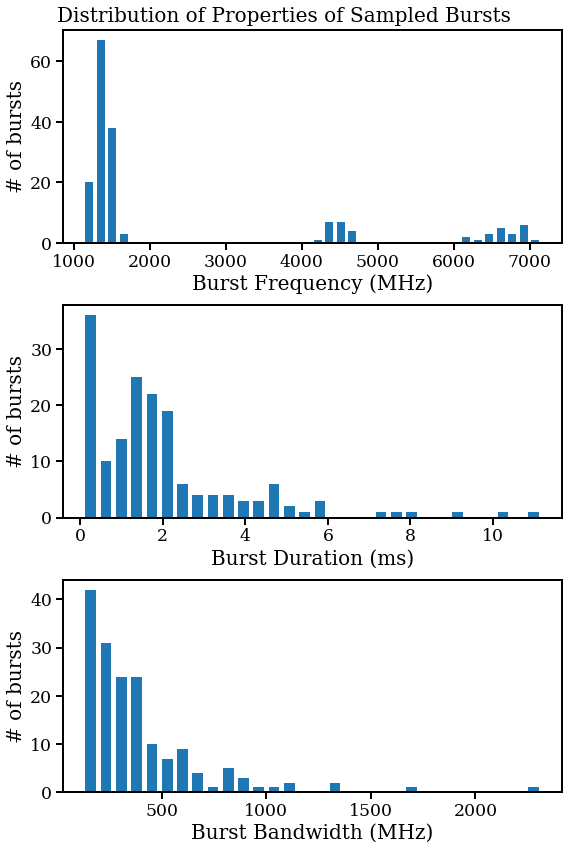

In [41]:
frames = bakeddata['frames']
labels = bakeddata['labels']
tot = 0
print(f"Total number of bursts: {sum([len(f) for f in frames])}")
for frame, label in zip(frames, labels):
    print(f"{label:38}: {len(frame)} bursts, {min(frame['center_f']):.0f} - {max(frame['center_f']):.0f} MHz,",
                      f"{min(frame['center_f_new']):.0f} - {max(frame['center_f_new']):.0f} (new) MHz,",
                      f"tw: {min(frame['tau_w_ms']):.2f} - {max(frame['tau_w_ms']):.2f} ms",
                      f"tw_FWHM_ms: {min(frame['tw_FWHM_ms']):.2f} - {max(frame['tw_FWHM_ms']):.2f} ms")
    display(frame[['center_f', 'center_f_new', 'tau_w_ms', 'tw_FWHM_ms', 'band_FWHM_mhz']])

allframes = pd.concat([f for f in frames])
display(allframes.loc[allframes['bandwidth (mhz)'] > 1000])

figsize = (8,12)
panels = plt.subplot_mosaic('A;B;C', figsize=figsize)[1]
allframes.hist('center_f', bins=40, grid=False, rwidth=0.7, ax=panels['A'])#35
allframes.hist('tau_w_ms', bins=30, grid=False, rwidth=0.7, ax=panels['B'])
allframes.hist('bandwidth (mhz)', bins=30, grid=False, rwidth=0.7, ax=panels['C'])

fontsize=20
plt.gcf().suptitle('Distribution of Properties of Sampled Bursts', fontsize=fontsize)
panels['A'].set_xlabel("Burst Frequency (MHz)", fontsize=fontsize)
panels['B'].set_xlabel('Burst Duration (ms)', fontsize=fontsize)
panels['C'].set_xlabel('Burst Bandwidth (MHz)', fontsize=fontsize)
for _, p in panels.items():
    p.set_title('')
    p.tick_params(labelsize='xx-large')
    p.set_ylabel('# of bursts', fontsize=fontsize)
plt.tight_layout()
# plt.savefig('figures/sample_distribution.pdf')

# Plot Frames

In [3]:
import itertools
plt.rcParams['text.usetex'] = False
frames = bakeddata['frames']
labels = bakeddata['labels']

def plotframes(frames, x, y, xlabel=None, ylabel=None, labels=labels, markersize=140, 
               fontsize=22, annotsize=14, logscale=False, figsize=(10, 9), 
               color='color', colorbar=False, cmap='viridis', edgecolors='k',
               xerrf=None, yerrf=None, ax=None):
    
    plt.rcParams["axes.linewidth"] = 2 # default is 0.8
    plt.rcParams['xtick.major.width'] = 2
    plt.rcParams['xtick.minor.width'] = 2
    plt.rcParams['ytick.major.width'] = 2
    plt.rcParams['ytick.minor.width'] = 2
    plt.rcParams['xtick.major.size'] = 7 # 3.5
    plt.rcParams['xtick.minor.size'] = 4 # 2
    plt.rcParams['ytick.major.size'] = 7 # 3.5
    plt.rcParams['ytick.minor.size'] = 4 # 2

    alldfs = pd.concat(frames)
    markers = itertools.cycle(['o', '^', 'v', 'd', 'p'])  # ['d', 'p', 'o', 'X']
    logscalex = logscale if type(logscale) == bool else logscale[0]
    logscaley = logscale if type(logscale) == bool else logscale[1]
    labels = labels if labels else ['']*len(frames)
    if ax: 
        figsize = ax.get_figure().get_size_inches()
    for i, (frame, label, mark) in enumerate(zip(frames, labels, itertools.cycle(markers))):
        colorbar = True if (colorbar and i == 0) else False
        edgecolor = (0, 0, 0, 0.7)
        tempax = frame.plot.scatter(ax=ax, x=x, y=y, figsize=figsize, 
                                    s=markersize, c=color, colorbar=colorbar, colormap=cmap,
                                    xerr=xerrf(frame) if xerrf else None,
                                    yerr=yerrf(frame) if yerrf else None,
                                    xlabel=xlabel,
                                    fontsize=fontsize, logy=logscaley, logx=logscalex, marker=mark, edgecolors=edgecolor, lw=1, label=label)
        if not ax: 
            ax = tempax
        # display(frame.head())
        
    if xlabel: ax.set_xlabel(xlabel, size=fontsize)
    if ylabel: ax.set_ylabel(ylabel, size=fontsize)
    # move error bars to the back
    for child in ax.get_children():
        if child.zorder == 2:
            child.set_zorder(-1)

    hdls, lbls = ax.get_legend_handles_labels()
    # order = [1, 2, 5, 3, 4, 0]
    # hdls = [hdls[i] for i in order]
    # lbls = [lbls[i] for i in order]
    ax.legend(hdls, lbls, fontsize='large')
    plt.tight_layout()
    return ax
######

# Slope/NuObs vs Duration (Single Fit)

red_chisq1 = 52236.360644724635, red_chisq2 = 23994.118475291398, red_chisq3 = 115777.98535043193


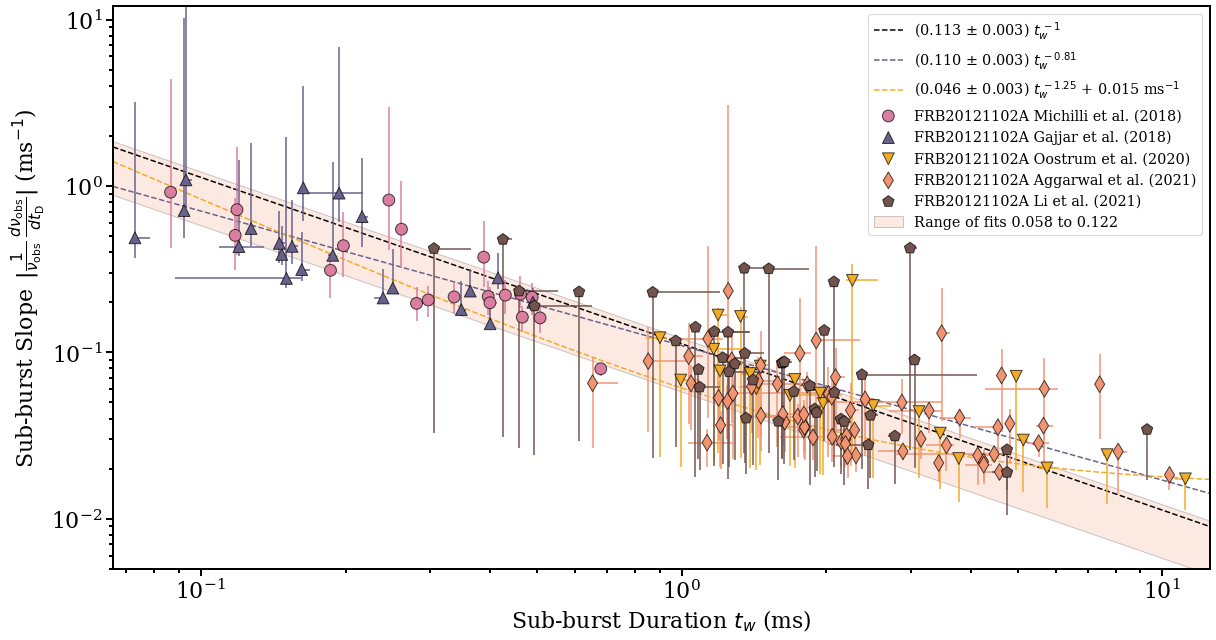

In [43]:
import matplotlib
from matplotlib import cm
frames = bakeddata['frames']
labels = bakeddata['labels']
from datetime import datetime
datestr = datetime.now().strftime('%b%d')

plt.rcParams["errorbar.capsize"] = 0
alldfs = pd.concat(frames)
cmap = cm.get_cmap('Paired')
for frame in frames:
    colors = cmap(np.interp(frame['center_f'], [min(alldfs['center_f']), max(alldfs['center_f'])], [0, 1]))
    colors = [matplotlib.colors.to_hex(color) for color in colors]
    frame['center_f_color'] = colors

ylabel = 'Sub-burst Slope $\\,\\left|\\frac{1}{\\nu_\\mathrm{obs}}\,\\frac{d\\nu_\\mathrm{obs}}{dt_\\mathrm{D}}\\right|$ (ms$^{-1}$)'
xlabel = "Sub-burst Duration $t_w$ (ms)"
ax = plotframes(frames, 'tau_w_ms', 'slope_over_nuobs', ylabel=ylabel, xlabel=xlabel, labels=labels, logscale=[True, True], figsize=(17, 9),
                color='color',
                yerrf=lambda f: driftlaw.limitedDMrangeerror(f)[1], xerrf=lambda f: driftlaw.limitedDMrangeerror(f)[0])

# y = Ax^-1; lny = -lnx + lnA
fit = driftlaw.fitodr(alldfs, errorfunc=driftlaw.log_error)
param, err = np.exp(fit.beta[0]), np.exp(fit.beta[0])*(np.exp(fit.sd_beta[0])-1)
ex = alldfs['tau_w_error']*np.sqrt(alldfs['red_chisq'])
ey = alldfs['slope error (mhz/ms)']/alldfs['center_f']*np.sqrt(alldfs['red_chisq'])
data_err = np.sqrt(ey**2 + ((param/alldfs['tau_w_ms'])*ex/alldfs['tau_w_ms'])**2)
residuals = alldfs['slope_over_nuobs'] - param/alldfs['tau_w_ms']
chisq = np.sum((residuals / data_err) ** 2)
red_chisq1 = chisq / (len(alldfs) - 1)

# y = Ax^n; lny = nlnx + lnA
odrmodel = scipy.odr.Model(lambda B, x: B[1]*x + B[0])
odrdata = scipy.odr.RealData(np.log(alldfs['tau_w_ms']), np.log(alldfs['slope_over_nuobs']), sx=driftlaw.log_error(alldfs)[0], sy=driftlaw.log_error(alldfs)[1])
odrjob = scipy.odr.ODR(odrdata, odrmodel, beta0=[1, 1])
odrjob.set_job(fit_type=0)
odrfit = odrjob.run()
odrerror = np.exp(odrfit.beta[0]) * (np.exp(odrfit.sd_beta[0])-1)
data_err = np.sqrt(ey**2 + ((np.exp(odrfit.beta[0])*alldfs['tau_w_ms']**odrfit.beta[1])*ex/alldfs['tau_w_ms'])**2)
residuals = alldfs['slope_over_nuobs'] - (np.exp(odrfit.beta[0])*alldfs['tau_w_ms']**odrfit.beta[1])
chisq = np.sum((residuals / data_err) ** 2)
red_chisq2 = chisq / (len(alldfs) - 1)

# print(f"{odrfit.beta[0] = } {odrfit.sd_beta[0] = } {odrfit.beta[1]}")

# y = Ax^n + c
odrmodel = scipy.odr.Model(lambda B, x: B[0]*x**B[1] + B[2])
odrdata = scipy.odr.RealData(alldfs['tau_w_ms'], alldfs['slope_over_nuobs'], sx=driftlaw.limitedDMrangeerror_odr(alldfs)[0], sy=driftlaw.limitedDMrangeerror_odr(alldfs)[1])
odrjob = scipy.odr.ODR(odrdata, odrmodel, beta0=[0.1, -1, 0])
odrjob.set_job(fit_type=0)
odrfit2 = odrjob.run()
odrerror2 = odrfit2.sd_beta[0]
data_err = np.sqrt(ey**2 + ((odrfit2.beta[0]*alldfs['tau_w_ms']**odrfit2.beta[1])*ex/alldfs['tau_w_ms'])**2)
residuals = alldfs['slope_over_nuobs'] - (odrfit2.beta[0]*alldfs['tau_w_ms']**odrfit2.beta[1])
chisq = np.sum((residuals / data_err) ** 2)
red_chisq3 = chisq / (len(alldfs) - 1)

# y = Ax^-1
odrmodel = scipy.odr.Model(lambda B, x: B[0]*x**-1)
odrdata = scipy.odr.RealData(alldfs['tau_w_ms'], alldfs['slope_over_nuobs'], sx=driftlaw.limitedDMrangeerror_odr(alldfs)[0], sy=driftlaw.limitedDMrangeerror_odr(alldfs)[1])
odrjob = scipy.odr.ODR(odrdata, odrmodel, beta0=[0.1, -1, 0])
odrjob.set_job(fit_type=0)
odrfit3 = odrjob.run()
odrerror3 = odrfit3.sd_beta[0]


fitextents = min(alldata['tau_w_ms'])*0.9, max(alldata['tau_w_ms'])*1.1
tw = np.linspace(fitextents[0], fitextents[1], num=1200)
# fit range is biggest of small and smallest of big of the ranges found for each dataset
fillrange = [0.058, 0.122]
ax.fill_between(tw, 0.058/tw, 0.122/tw, alpha=0.2, color=tagColors[3], edgecolor='k', label=f'Range of fits {fillrange[0]} to {fillrange[1]}', zorder=-10)

plt.plot(tw, param/tw, color='k', ls='--', label=f'({param:.3f} $\pm$ {err:.3f}) $t_w^{{\,-1}}$', zorder=-2)

plt.plot(tw, np.exp(odrfit.beta[0])*tw**odrfit.beta[1], color=tagColors[1], ls='--', label=f'({np.exp(odrfit.beta[0]):.3f} $\pm$ {odrerror:.3f}) $t_w^{{\,{odrfit.beta[1]:.2f}}}$', zorder=-2)

plt.plot(tw, odrfit2.beta[0]*tw**odrfit2.beta[1]+odrfit2.beta[2], color=tagColors[2], ls='--', 
         label=f'({odrfit2.beta[0]:.3f} $\pm$ {odrerror2:.3f}) $t_w^{{\,{odrfit2.beta[1]:.2f}}}$ {"+" if odrfit2.beta[2] > 0 else "-"} {abs(odrfit2.beta[2]):.3f} ms$^{{-1}}$', zorder=-2)

# plt.plot(tw, odrfit3.beta[0]/tw, color='k', ls='--', label=f'({odrfit3.beta[0]:.3f} $\pm$ {odrerror3:.3f}) $t_w^{{\,-1}}$', zorder=-2)

plt.legend(fontsize='x-large')
# print(f"{param = }, {err = }")
ax.set_xlim(min(tw), max(tw))
ax.set_ylim(0.005, 12)
print(f"{red_chisq1 = }, {red_chisq2 = }, {red_chisq3 = }")
# plt.savefig(f'figures/SlopevDuration_{datestr}.pdf')

# Duration vs Nu

[ 6.58680570e+03 -1.09256515e+00] [ 5.05342369 -1.51516766] [3.3627696]
odrfit.beta[0] = 204.390670705589 245.3843750875306
odrrecip.beta[0] = 1471.768456235707 48.33764026737814


[Text(1000, 0, '1000'),
 Text(2000, 0, '2000'),
 Text(3000, 0, '3000'),
 Text(4000, 0, '4000'),
 Text(6000, 0, '6000')]

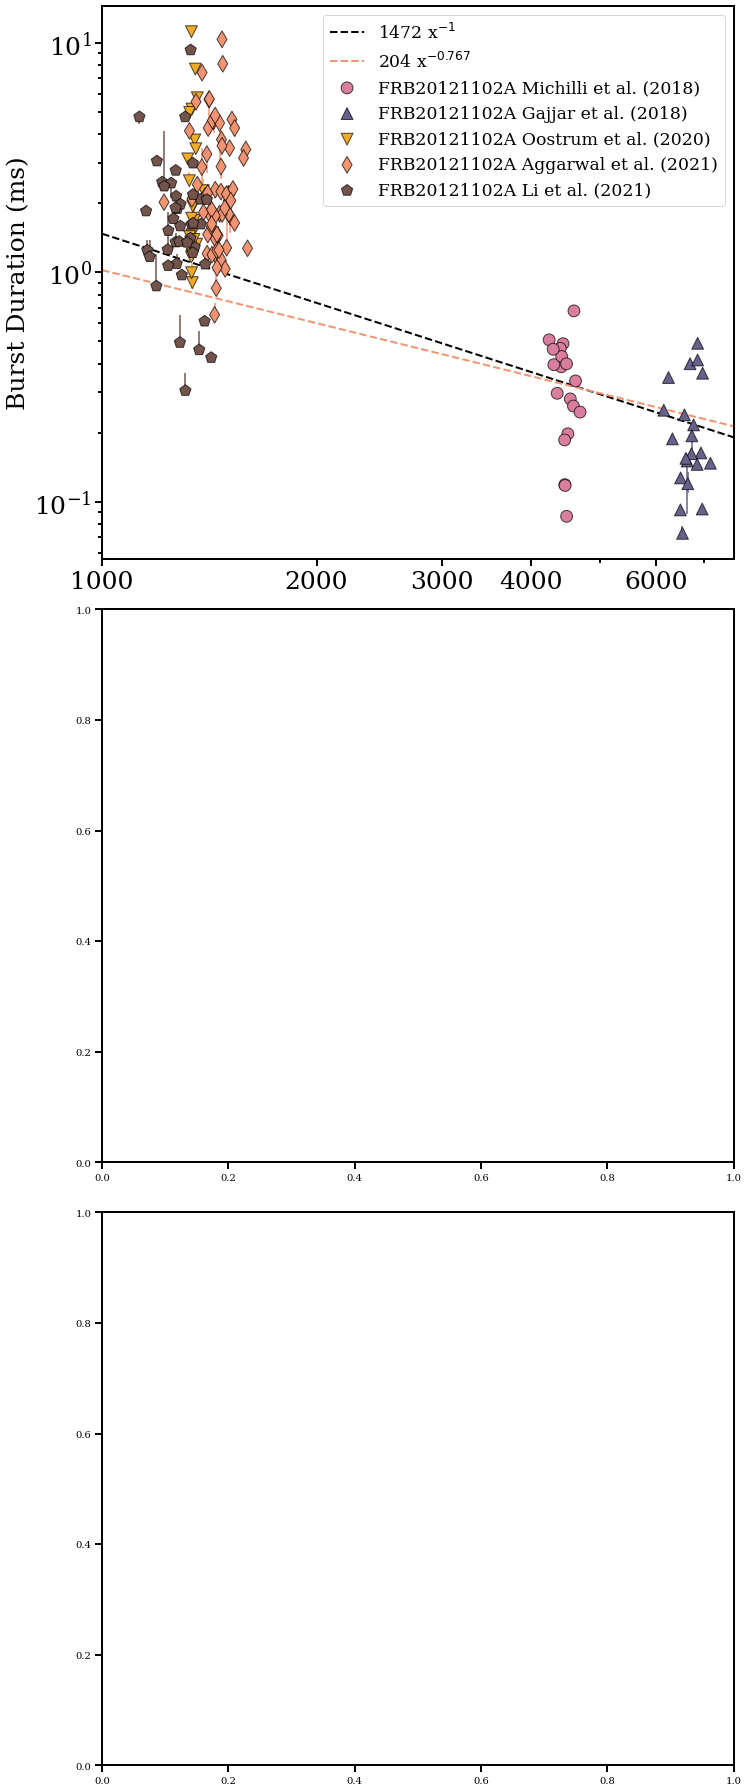

In [52]:
# eq. 2 tw = tau_w*nu_0 / nu_obs
importlib.reload(driftlaw)
frames = bakeddata['frames']
labels = bakeddata['labels']
from datetime import datetime
datestr = datetime.now().strftime('%b%d')
propfigure, propaxs = plt.subplots(3, 1, figsize=(10.5, 25), facecolor='w')

ax = plotframes(frames, 'center_f', 'tau_w_ms', xlabel="", ylabel="Burst Duration (ms)", labels=labels, 
                logscale=[True, True], yerrf=lambda f: driftlaw.limitedDMrangeerror(f)[0], fontsize=25, ax=propaxs[0])
alldfs = pd.concat([frame for frame in frames])
ey = driftlaw.rangeerror(alldfs)[0]
sigma = (alldfs['tau_w_ms'] + (ey[0][0]+ey[0][1])/2 ) / alldfs['tau_w_ms']

p0 = None
popt, pcov = scipy.optimize.curve_fit(lambda x, a, n: a*(x**n), alldfs['center_f'], alldfs['tau_w_ms'], sigma=None, absolute_sigma=False)
precip, pcov = scipy.optimize.curve_fit(lambda x, a: a*(x**-1), alldfs['center_f'], alldfs['tau_w_ms'], sigma=None, absolute_sigma=False)
logrecip_p, pcov = scipy.optimize.curve_fit(lambda x, a: a - x, np.log10(alldfs['center_f']), np.log10(alldfs['tau_w_ms']), sigma=None, absolute_sigma=False)
log_p,   pcov = scipy.optimize.curve_fit(lambda x, a, n: a + n*x, np.log10(alldfs['center_f']), np.log10(alldfs['tau_w_ms']), sigma=None, absolute_sigma=False)
print(popt, log_p, logrecip_p)

odrmodel = scipy.odr.Model(lambda B, x: B[0]*x**B[1])
sx = alldfs['f_res (mhz)']/np.sqrt(12)
odrdata = scipy.odr.RealData(alldfs['center_f'], alldfs['tau_w_ms'], sx=sx, sy=driftlaw.limitedDMrangeerror_odr(alldfs)[0])
odrjob = scipy.odr.ODR(odrdata, odrmodel, beta0=[3, -1])
odrjob.set_job(fit_type=0)
odrfit = odrjob.run()
print(f"{odrfit.beta[0] = } {odrfit.sd_beta[0]}")

odrmodel = scipy.odr.Model(lambda B, x: B[0]*x**-1)
odrdata = scipy.odr.RealData(alldfs['center_f'], alldfs['tau_w_ms'], sx=sx, sy=driftlaw.limitedDMrangeerror_odr(alldfs)[0])
odrjob = scipy.odr.ODR(odrdata, odrmodel, beta0=[3, -1])
odrjob.set_job(fit_type=0)
odrrecip = odrjob.run()
print(f"{odrrecip.beta[0] = } {odrrecip.sd_beta[0]}")

x = np.linspace(1e3, 7.7e3)
zorder = -2
# ax.plot(x, (10**log_p[0])*x**log_p[1], 'g', linestyle='--', lw=2, label=f'${(10**log_p[0]):.0f} x^{{{log_p[1]:.3f}}}$', zorder=zorder)
# ax.plot(x, (10**logrecip_p[0])/x, 'y', linestyle='--', lw=2, label=f'{logrecip_p[0]:.2f} / x', zorder=zorder)
# ax.plot(x, (popt[0]*x**popt[1]), 'k', linestyle='--', lw=2, label=f'{popt[0]:.2f} x$^{{{popt[1]:.4f}}}$', zorder=zorder)
# ax.plot(x, (precip[0]*x**-1), 'c', linestyle='--', lw=2, label=f'{precip[0]:.2f} x$^{{-1}}$', zorder=zorder)
ax.plot(x, (odrrecip.beta[0]*x**odrrecip.beta[1]), 'k', linestyle='--', lw=2, label=f'{odrrecip.beta[0]:.0f} x$^{{-1}}$', zorder=zorder)
ax.plot(x, (odrfit.beta[0]*x**odrfit.beta[1]), tagColors[3], linestyle='--', lw=2, label=f'{odrfit.beta[0]:.0f} x$^{{{odrfit.beta[1]:.3f}}}$', zorder=zorder)
ax.legend(fontsize='xx-large')
ax.set_xlim(1000, 7700)
xticks = [1000, 2000, 3000, 4000, 6000]
ax.set_xticks(xticks)
ax.set_xticklabels(xticks)

# plt.savefig(f'figures/DurationvFreq_{datestr}.pdf')

# Slope vs Frequency

In [53]:
# eq 1: slope = - A*nuobs / tw
frames = bakeddata['frames']
labels = bakeddata['labels']
from datetime import datetime
datestr = datetime.now().strftime('%b%d')

eslope = lambda frame: [np.array([frame['slope_abs'] - frame['lim_slope_min'], frame['lim_slope_max'] - frame['slope_abs']])]
ax = plotframes(frames, 'center_f', 'slope_abs', labels=None, xlabel="", ylabel="|Slope| (MHz/ms)", logscale=True, yerrf=eslope, fontsize=25, ax=propaxs[1])

ey = eslope(frame)
sigma = (frame['slope_abs'] + (ey[0][0]+ey[0][1])/2) / frame['slope_abs']

linepo, pcov = scipy.optimize.curve_fit(lambda x, a: a*x, (frame['center_f']), (frame['slope_abs']), sigma=None, absolute_sigma=False)
quadpo, pcov = scipy.optimize.curve_fit(lambda x, a: a*x**2, (frame['center_f']), (frame['slope_abs']), sigma=None, absolute_sigma=False)
powerpo, pcov = scipy.optimize.curve_fit(lambda x, a, n: a+n*x, np.log10(frame['center_f']), np.log10(frame['slope_abs']), sigma=None, absolute_sigma=False, p0=[np.log10(1.8e-8), 1])
print(powerpo)

# y = Ax^2
odrmodel = scipy.odr.Model(lambda B, x: B[0]*x**2)
sx = alldfs['f_res (mhz)']/np.sqrt(12)
sy = np.sqrt(alldfs['red_chisq'])*alldfs['slope error (mhz/ms)']
# sy = np.maximum(*[alldfs['slope_abs'] - alldfs['lim_slope_min'], alldfs['lim_slope_max'] - alldfs['slope_abs']])
odrdata = scipy.odr.RealData(alldfs['center_f'], alldfs['slope_abs'], sx=sx, sy=sy)
odrjob = scipy.odr.ODR(odrdata, odrmodel, beta0=[1])
odrjob.set_job(fit_type=0)
odrfit = odrjob.run()
odrerror = odrfit.sd_beta[0]

# y = Ax^n
odrmodel = scipy.odr.Model(lambda B, x: B[0]*x**B[1])
sx = alldfs['f_res (mhz)']/np.sqrt(12)
odrdata = scipy.odr.RealData(alldfs['center_f'], alldfs['slope_abs'], sx=sx, sy=np.maximum(driftlaw.rangeerror(alldfs)[1][0][0], driftlaw.rangeerror(alldfs)[1][0][1]))
odrjob = scipy.odr.ODR(odrdata, odrmodel, beta0=[1, 1])
odrjob.set_job(fit_type=0)
odrfit2 = odrjob.run()
odrerror2 = odrfit2.sd_beta[0]

# y = Ax^n + C
# odrmodel = scipy.odr.Model(lambda B, x: B[1]*x + B[0])
# sx = alldfs['f_res (mhz)']/np.sqrt(12)
# odrdata = scipy.odr.RealData(np.log(alldfs['center_f']), np.log(alldfs['slope_abs']), sx=sx, sy=np.maximum(driftlaw.rangeerror(alldfs)[1][0][0], driftlaw.rangeerror(alldfs)[1][0][1]))
# odrjob = scipy.odr.ODR(odrdata, odrmodel, beta0=[1, 1])
# odrjob.set_job(fit_type=0)
# odrfit3 = odrjob.run()
# odrerror3 = np.exp(odrfit3.beta[0]) * (np.exp(odrfit3.sd_beta[0])-1)

# ax.plot(x, (linepo[0])*x, 'k', linestyle='--', lw=2, label=f'${{{linepo[0]:.4f}}} x$')
# ax.plot(x, (quadpo[0])*x**2, 'b', linestyle='--', lw=2, label=f'${{{quadpo[0]:.4f}}} x^2$')
# ax.plot(x, 10**powerpo[0]*(x**powerpo[1]), 'g', linestyle='--', lw=2, label=f'${{{10**powerpo[0]:.2e}}} \cdot x^{{{powerpo[1]:.3f}}}$')
x = np.linspace(1e3, 7.7e3)
ax.plot(x, odrfit.beta[0]*x**2, color='k', ls='--', label=f'({odrfit.beta[0]:.1e} $\pm$ {odrerror:.0e}) $x^{{\,2}}$', zorder=-2)

ax.plot(x, odrfit2.beta[0]*x**odrfit2.beta[1], color=tagColors[3], ls='--', label=f'({odrfit2.beta[0]:.1e} $\pm$ {odrerror2:.0e}) $x^{{\,{odrfit2.beta[1]:.3f}}}$', zorder=-2)

ax.legend(fontsize='xx-large', loc='upper left')
ax.set_xlim(1000, 7700)
xticks = [1000, 2000, 3000, 4000, 6000]
ax.set_xticks(xticks)
ax.set_xticklabels(xticks)
# plt.savefig(f'figures/SlopevFreq_{datestr}.pdf')

[-14.04368172   5.18028278]


[Text(1000, 0, '1000'),
 Text(2000, 0, '2000'),
 Text(3000, 0, '3000'),
 Text(4000, 0, '4000'),
 Text(6000, 0, '6000')]

<Figure size 432x288 with 0 Axes>

# Slope/nu^2 vs nu

In [54]:
# eq 9: 1/nuobs^2 * slope = -1/(nu_0*tau_D)
frames = bakeddata['frames']
labels = bakeddata['labels']
from datetime import datetime
datestr = datetime.now().strftime('%b%d')

for frame in frames: 
    frame['slope_abs_nuobssq'] = frame['slope_abs']/frame['center_f']**2/1000
    
eslopenusq = lambda frame: [np.array([frame['slope_abs_nuobssq'] - frame['lim_slope_nu_min']/frame['center_f']/1000, frame['lim_slope_nu_max']/frame['center_f']/1000 - frame['slope_abs_nuobssq']])]
ylabel = '$\\,\\left|\\frac{1}{\\nu^2_\\mathrm{obs}}\,\\frac{d\\nu_\\mathrm{obs}}{dt_\\mathrm{D}}\\right|$ (ms$^{-1}$)'
ax = plotframes(frames, 'center_f', 'slope_abs_nuobssq', labels=None, xlabel="Frequency (MHz)", ylabel=ylabel, logscale=True, yerrf=eslopenusq, fontsize=25, ax=propaxs[2])
popt, pcov = scipy.optimize.curve_fit(lambda x, a: a, (frame['center_f']), (frame['slope_abs_nuobssq']))#, sigma=sigma, absolute_sigma=True)
# print(popt[0])

odrmodel = scipy.odr.Model(lambda B, x: B[0]+0*x)
sy = np.maximum(*eslopenusq(alldfs)[0])
sy = np.sqrt(alldfs['red_chisq'])*alldfs['slope error (mhz/ms)'] / alldfs['center_f']**2
odrdata = scipy.odr.RealData(alldfs['center_f'], alldfs['slope_abs_nuobssq'], sx=alldfs['f_res (mhz)']/np.sqrt(12), sy=sy)
odrjob = scipy.odr.ODR(odrdata, odrmodel, beta0=[1e-8])
odrjob.set_job(fit_type=0)
odrfit = odrjob.run()
odrerror = odrfit.sd_beta[0]

# y = Ax^n + c
odrmodel = scipy.odr.Model(lambda B, x: B[0]*x**B[1] + B[2])
odrdata = scipy.odr.RealData(alldfs['center_f'], alldfs['slope_abs_nuobssq'], sx=alldfs['f_res (mhz)']/np.sqrt(12), sy=sy)
odrjob = scipy.odr.ODR(odrdata, odrmodel, beta0=[1e-8, 0, 0])
odrjob.set_job(fit_type=0)
odrfit2 = odrjob.run()
odrerror2 = odrfit2.sd_beta[0]

x = np.linspace(1e3, 7.7e3)
# ax.plot(x, [popt[0]]*len(x), 'b', linestyle='--', lw=2, label=f'$B = {{{popt[0]:.2e}}}$')

# ax.plot(x, [odrfit.beta[0]]*len(x), 'k', linestyle='--', label=f'B = {odrfit.beta[0]:.2e} $\pm$ {odrerror:.0e}')

print(odrfit2.beta)
ax.plot(x, odrfit2.beta[0]*x**odrfit2.beta[1]+odrfit2.beta[2], color='k', ls='--', 
         label=f'B = ({odrfit2.beta[0]:.2e} $\pm$ {odrerror2:.0e}) $\\nu^{{\,{odrfit2.beta[1]:.0f}}}$ {"+" if odrfit2.beta[2] >= 0 else "-"} {abs(odrfit2.beta[2]):.0f}', zorder=-2)

ax.legend(fontsize='xx-large', loc='upper left')
ax.set_xlim(1000, 7700)
xticks = [1000, 2000, 3000, 4000, 6000]
ax.set_xticks(xticks)
ax.set_xticklabels(xticks)
# plt.savefig(f'figures/SlopeOverNusqvFreq_{datestr}.pdf')


[4.27493426e-08 0.00000000e+00 0.00000000e+00]


[Text(1000, 0, '1000'),
 Text(2000, 0, '2000'),
 Text(3000, 0, '3000'),
 Text(4000, 0, '4000'),
 Text(6000, 0, '6000')]

<Figure size 432x288 with 0 Axes>

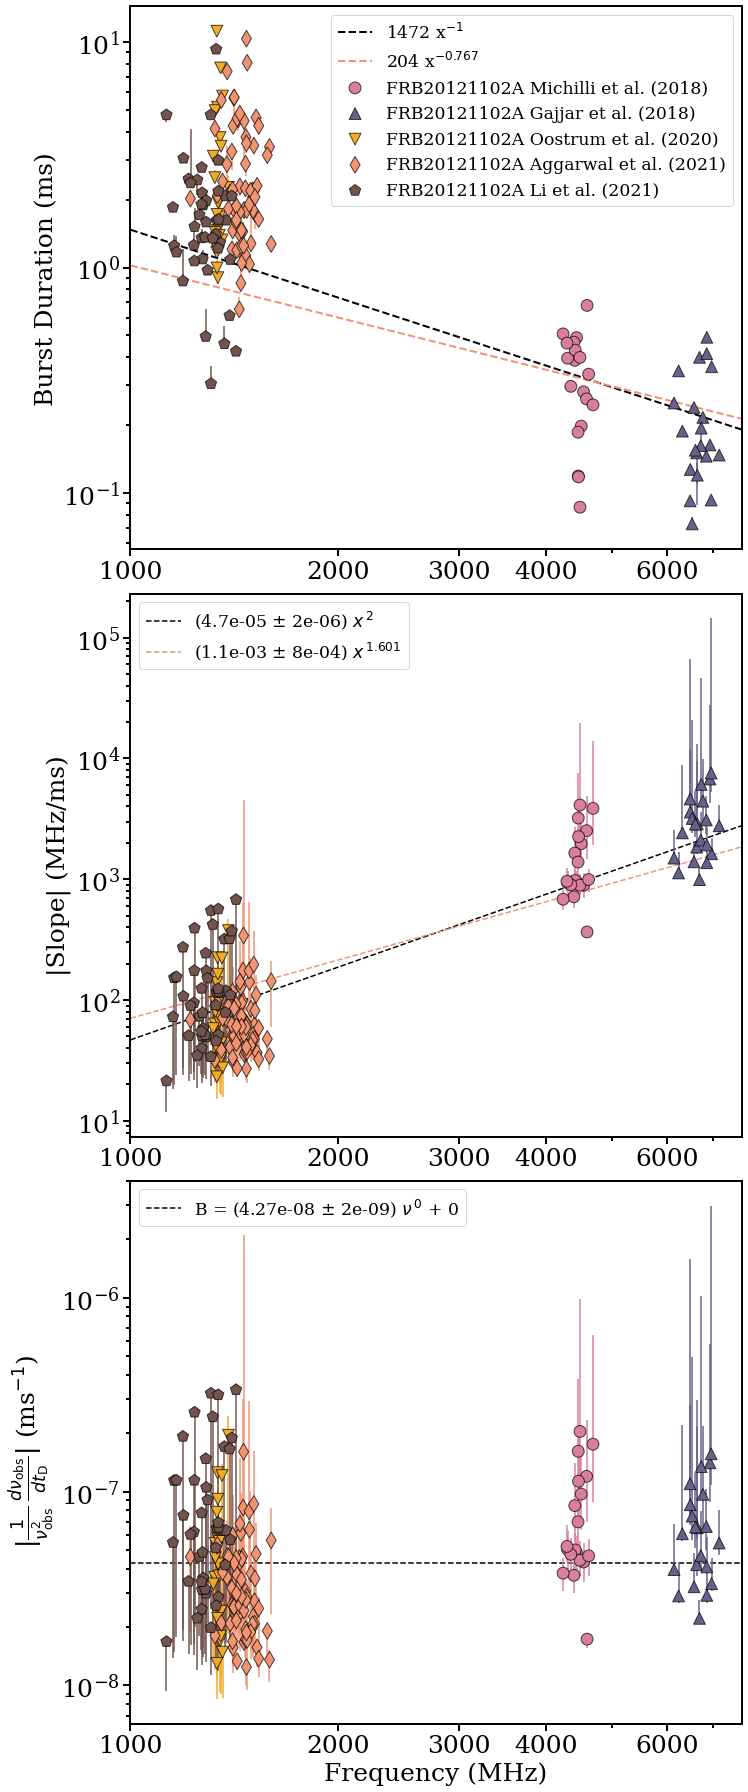

In [56]:
propfigure.tight_layout()
propfigure.axes[1].tick_params(labelsize=25)
propfigure.axes[2].tick_params(labelsize=25)
propfigure.savefig(f'figures/PropvFreq_{datestr}.pdf')
propfigure

# Bandwidth vs Frequency

[Text(1000, 0, '1000'),
 Text(2000, 0, '2000'),
 Text(3000, 0, '3000'),
 Text(4000, 0, '4000'),
 Text(6000, 0, '6000')]

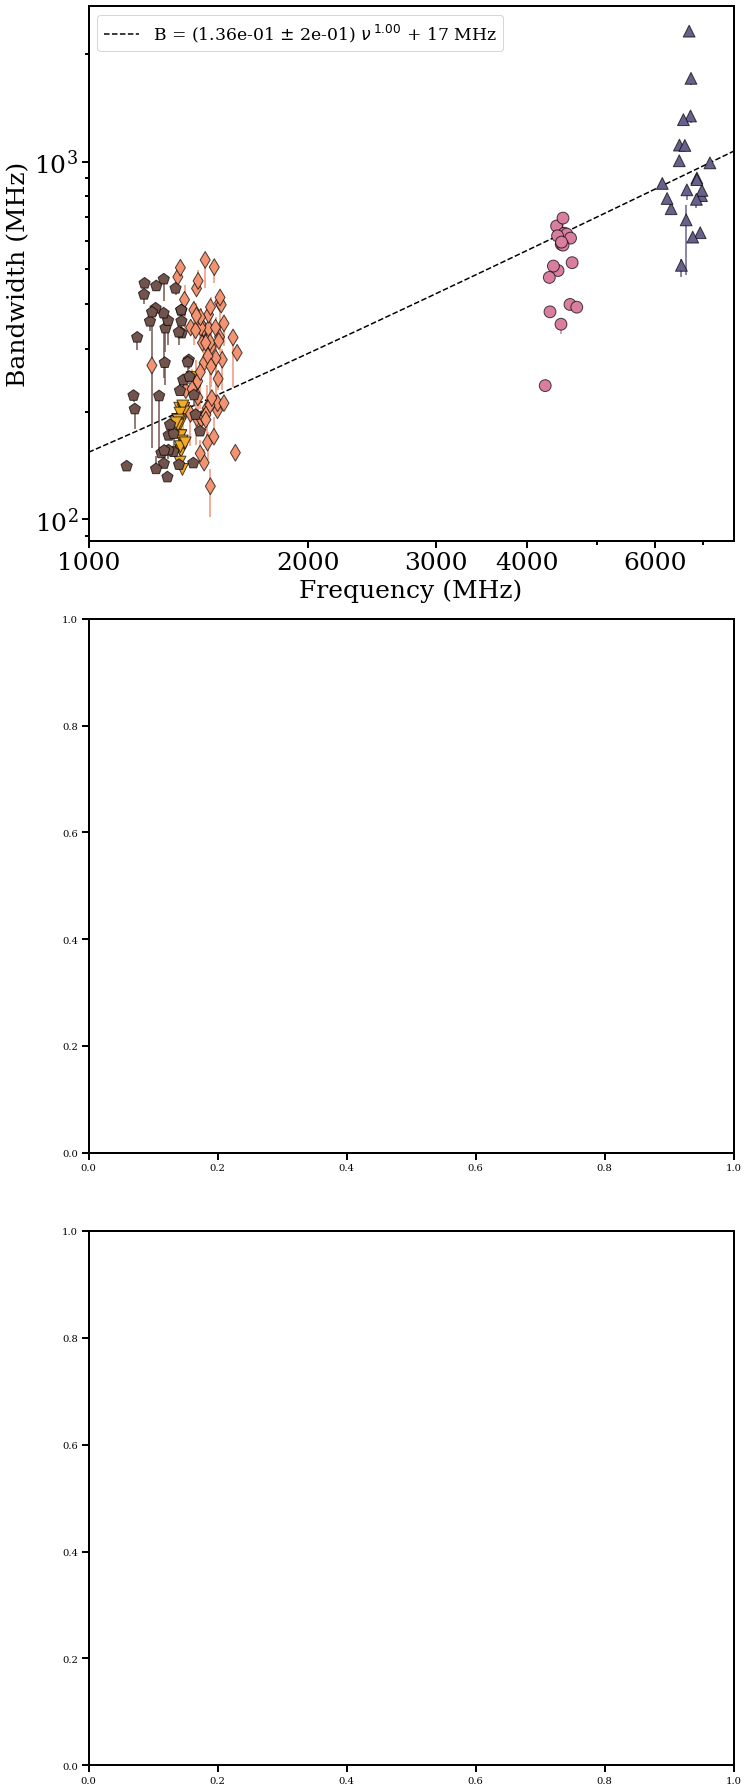

In [63]:
# Bandwidth is linear with nu (fig 5 of triggered paper). small bandwidths might cluster around nu_0. 
frames = bakeddata['frames']
labels = bakeddata['labels']
from datetime import datetime
datestr = datetime.now().strftime('%b%d')
bandfig, bandaxs = plt.subplots(3, 1, figsize=(10.5, 25), facecolor='w')

ebandwidth = lambda f: [np.array([f['bandwidth (mhz)'] - f['lim_band_min'], f['lim_band_max'] - f['bandwidth (mhz)']])]

ax = plotframes(frames, 'center_f', 'bandwidth (mhz)', labels=None, xlabel="Frequency (MHz)", ylabel="Bandwidth (MHz)", logscale=[True, True], yerrf=ebandwidth, fontsize=25, ax=bandaxs[0])
alldfs = pd.concat([frame for frame in frames])

# y = Ax^n + c
sy = np.sqrt(alldfs['red_chisq'])*alldfs['max_sigma_error']
odrmodel = scipy.odr.Model(lambda B, x: B[0]*x**B[1] + 1*B[2])
odrdata = scipy.odr.RealData(alldfs['center_f'], alldfs['bandwidth (mhz)'], sx=alldfs['f_res (mhz)'], sy=sy)
odrjob = scipy.odr.ODR(odrdata, odrmodel, beta0=[1, 1, 0])
odrjob.set_job(fit_type=0)
odrfit = odrjob.run()
odrerror = odrfit.sd_beta[0]

x = np.linspace(1e3, 7.7e3)
ax.plot(x, odrfit.beta[0]*x**odrfit.beta[1]+odrfit.beta[2], color='k', ls='--', 
         label=f'B = ({odrfit.beta[0]:.2e} $\pm$ {odrerror:.0e}) $\\nu^{{\,{odrfit.beta[1]:.2f}}}$ {"+" if odrfit.beta[2] >= 0 else "-"} {abs(odrfit.beta[2]):.0f} MHz', zorder=-2)

ax.legend(fontsize='xx-large')
ax.set_xlim(1000, 7700)
xticks = [1000, 2000, 3000, 4000, 6000]
ax.set_xticks(xticks)
ax.set_xticklabels(xticks)
# plt.savefig(f'figures/BandvFreq_{datestr}.pdf')

# Bandwidth vs Duration

In [64]:
# I dont know but looks inverse to me. Seems to be nu^2/5
frames = bakeddata['frames']
labels = bakeddata['labels']
from datetime import datetime
datestr = datetime.now().strftime('%b%d')

ebandwidth = lambda f: [np.array([f['bandwidth (mhz)'] - f['lim_band_min'], f['lim_band_max'] - f['bandwidth (mhz)']])]

ax = plotframes(frames, 'tau_w_ms', 'bandwidth (mhz)', labels=None, xlabel="Duration (ms)", ylabel="Bandwidth (MHz)", logscale=[True, True], ax=bandaxs[1],
                xerrf=lambda f: driftlaw.limitedDMrangeerror(f)[0], yerrf=ebandwidth, fontsize=25)
alldfs = pd.concat([frame for frame in frames])

# y = Ax^n
sy = np.sqrt(alldfs['red_chisq'])*alldfs['max_sigma_error']
sx = driftlaw.log_error(alldfs)[0]
odrmodel = scipy.odr.Model(lambda B, x: B[0] + B[1]*x)
odrdata = scipy.odr.RealData(np.log(alldfs['tau_w_ms']), np.log(alldfs['bandwidth (mhz)']), sx=sx, sy=np.log(sy))
odrjob = scipy.odr.ODR(odrdata, odrmodel, beta0=[1, -1.5, 0])
odrjob.set_job(fit_type=0)
odrfit = odrjob.run()
odrerror = np.exp(odrfit.beta[0]) * (np.exp(odrfit.sd_beta[0])-1)

tw = np.linspace(fitextents[0], fitextents[1], num=1200)
ax.plot(tw, np.exp(odrfit.beta[0])*tw**odrfit.beta[1], color='k', ls='--',
        label=f'B = ({np.exp(odrfit.beta[0]):.0f} $\pm$ {odrerror:.0f}) $\\nu^{{\,{odrfit.beta[1]:.2f}}}$', zorder=-2)
ax.legend(fontsize='xx-large')
# plt.savefig(f'figures/BandvDuration_{datestr}.pdf')

<Figure size 432x288 with 0 Axes>

# Bandwidth vs Slope

In [65]:
# Just trying
frames = bakeddata['frames']
labels = bakeddata['labels']
from datetime import datetime
datestr = datetime.now().strftime('%b%d')

ebandwidth = lambda f: [np.array([f['bandwidth (mhz)'] - f['lim_band_min'], f['lim_band_max'] - f['bandwidth (mhz)']])]

ax = plotframes(frames, 'slope_abs', 'bandwidth (mhz)', labels=None, xlabel="Slope (MHz/ms)", ylabel="Bandwidth (MHz)", logscale=[True, True], ax=bandaxs[2],
                xerrf=lambda f: driftlaw.limitedDMrangeerror(f)[1], yerrf=ebandwidth, fontsize=25)
alldfs = pd.concat([frame for frame in frames])

# y = Ax^n
sy = np.sqrt(alldfs['red_chisq'])*alldfs['max_sigma_error']
odrmodel = scipy.odr.Model(lambda B, x: B[0] + B[1]*x)
odrdata = scipy.odr.RealData(np.log(alldfs['slope_abs']), np.log(alldfs['bandwidth (mhz)']), sx=driftlaw.log_error(alldfs)[1], sy=np.log(sy))
odrjob = scipy.odr.ODR(odrdata, odrmodel, beta0=[1, 1])
odrjob.set_job(fit_type=0)
odrfit = odrjob.run()
odrerror = np.exp(odrfit.beta[0]) * (np.exp(odrfit.sd_beta[0])-1)

slopes = np.linspace(18, 7500, num=1200)
ax.plot(slopes, np.exp(odrfit.beta[0])*slopes**odrfit.beta[1], color='k', ls='--',
        label=f'B = ({np.exp(odrfit.beta[0]):.0f} $\pm$ {odrerror:.0f}) $\\nu^{{\,{odrfit.beta[1]:.2f}}}$', zorder=-2)

ax.legend(fontsize='xx-large')
# plt.savefig(f'figures/BandvSlope_{datestr}.pdf')

<Figure size 432x288 with 0 Axes>

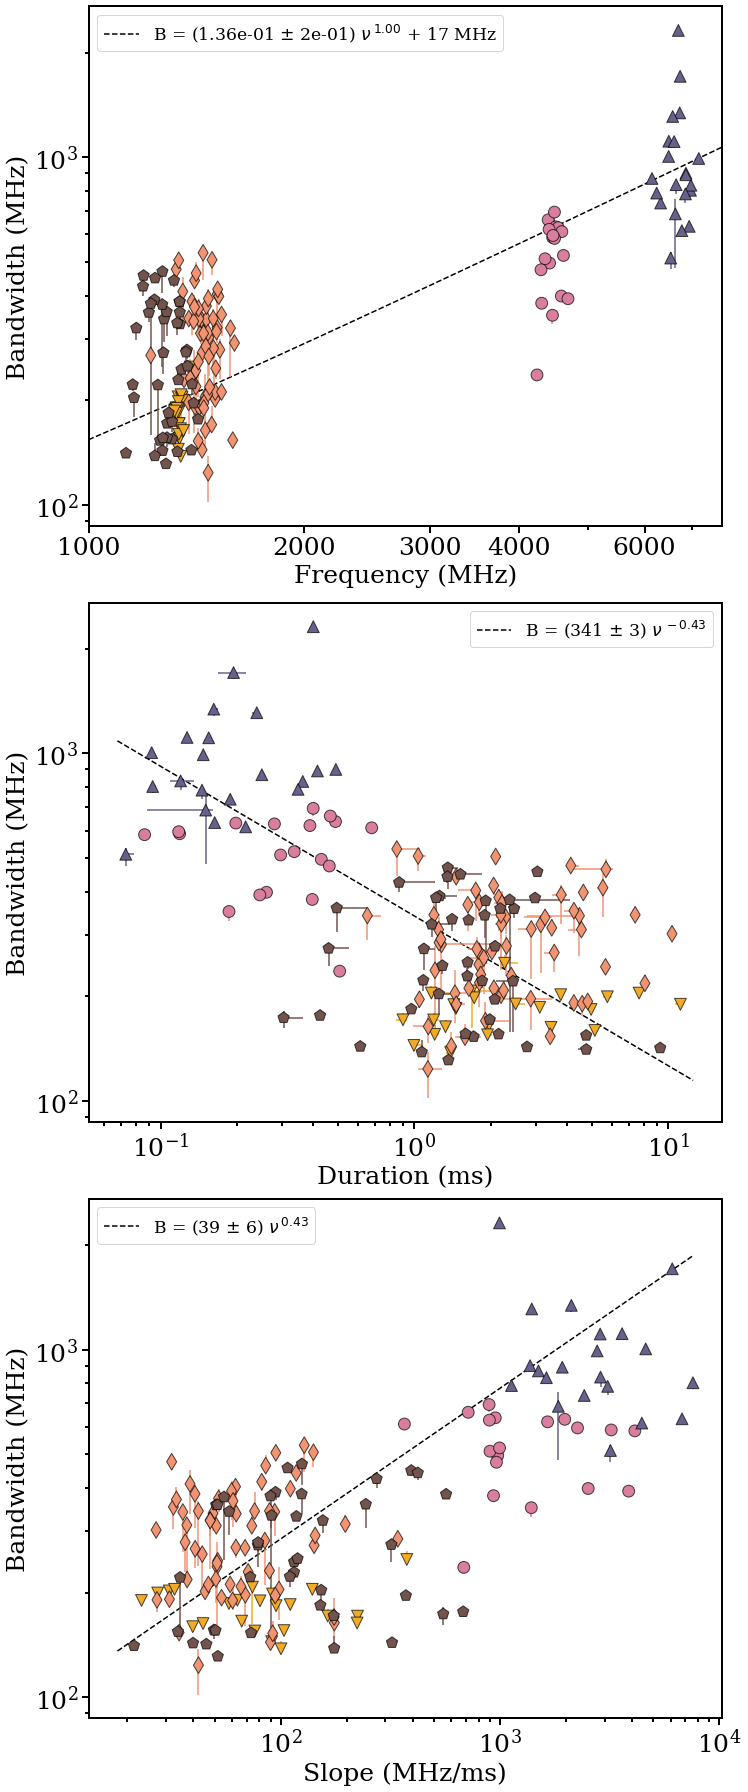

In [67]:
bandfig.tight_layout()
bandfig.axes[1].tick_params(labelsize=25)
bandfig.axes[2].tick_params(labelsize=25)
bandfig.savefig(f'figures/Bandwidthfigs_{datestr}.pdf')
bandfig

# Drift Rates

## Data prepare

In [40]:
# See burst metadata to find bursts with multiple components
import glob, shutil
from datetime import datetime
datestr = datetime.now().strftime('%b%d')

def combinemasks():
    maskfiles = ['aggarwalmasks_Jun17_2022.npy','oostrummasks_may2_2022.npy','li_masks_may3.npy']
    combined = {}
    for maskfile in maskfiles:
        combined = {**combined, **np.load(maskfile, allow_pickle=True)[0]}
    combined
    np.save('driftratemasks_jul16_22.npy', [combined])
    
# driftwfalls = ['M01_0055','M01_0095','M01_0163','M01_0264','M01_0388','M01_0415','M01_0487','M01_0576','M01_0634','M009','M010','M013','B093','B109','B121','11A','12A']
driftwfalls = [
    'M009',
    'M010',
    'M013',
    '11A',
    '12A',
    '12B',
    'B003', # new
    'B032', # new
    'B071', # new
    'B093',
    'B109',
    'B121',
    'M01_0055',
    'M01_0095',
    'M01_0163',
    'M01_0264',
    'M01_0388',
    'M01_0415',
    'M01_0487',
    'M01_0576',
    'M01_0634',
    'M01_0630' # new
]
# del allsources
if 'allsources' not in locals():
    print("Loading...")
    dfs = []
    for sfile, chanspace in zip(sources_filenames, chanspaces):
        df = pd.read_csv(sfile)
        df = df.set_index("name")
        print(sfile)
        df = driftlaw.computeModelDetails(df, channelSpaceDuration=chanspace)
        dfs.append(df)
    allsources = pd.concat([f for f in dfs])
len(allsources)

# driftdfs = pd.concat([allsources.loc[allsources.index.str.contains(wfall)] for wfall in driftwfalls])
driftdfs = []
for wfall in driftwfalls:
    df = allsources.loc[allsources.index.str.contains(wfall)]
    if wfall == 'B121': # workaround for FRB121102 string match
        df = df.loc['B121']
    driftdfs.append(df)
driftdfs = pd.concat(driftdfs)

# display(driftdfs)
idx = []
for f in driftdfs.index.unique():
    if f[-2:] not in ['_a', '_b', '_c', '_d', '_e', '_f', '_g']:
        idx.append(f)
driftdfs = driftdfs.loc[idx]
csvout = f'results/FRB121102_driftrates_{len(driftdfs)}rows_{datestr}.csv'
driftdfs.to_csv(csvout)
print(f"Saved: {csvout}")

datadirs = [
    '/mnt/b/dev/frbrepeaters/data/aggarwal2021/*.npz',
    '/mnt/b/dev/frbrepeaters/data/gajjar2018/*.npz',
    '/mnt/b/dev/frbrepeaters/data/michilli2018/*.npz',
    '/mnt/e/Li2021/samp_wait*/*.npz',
]
allfiles = [file for files in [glob.glob(datadir) for datadir in datadirs] for file in files]
burstfiles = []
for wfall in driftwfalls:
    print(wfall)
    for file in allfiles:
        if wfall in file:
            if wfall == 'B121' or wfall == 'B093' or wfall == 'B003': 
                continue
            else:
                burstfiles.append(file)
burstfiles.append('/mnt/b/dev/frbrepeaters/data/aggarwal2021/B121.1.npz')
burstfiles.append('/mnt/b/dev/frbrepeaters/data/aggarwal2021/B093.1.npz')
burstfiles.append('/mnt/b/dev/frbrepeaters/data/aggarwal2021/B003.1.npz')
burstfiles
for burstfile in burstfiles:
    outfile = f'/mnt/b/dev/frbrepeaters/data/driftrates/{burstfile.split("/")[-1]}'
    if not os.path.exists(outfile):
        shutil.copyfile(burstfile, outfile)


Loading...
results/FRB121102_michilli_924rows_Jul07.csv
results/GajjarFRB121102_1092rows_Jul16.csv
results/FRB121102_oostrum_1025rows_Jul07.csv
results/FRB121102_aggarwal_4785rows_Jul07.csv
results/FRB121102_Li_419rows_Jul07.csv
results/FRB121102_Li_waittimes_1758rows_Jul07.csv
Saved: results/FRB121102_driftrates_922rows_Jul17.csv
M009
M010
M013
11A
12A
12B
B003
B032
B071
B093
B109
B121
M01_0055
M01_0095
M01_0163
M01_0264
M01_0388
M01_0415
M01_0487
M01_0576
M01_0634
M01_0630


## Drift Rates Figure


# FRB20121102A Michilli et al. (2018):
>> DM range after maximizing bursts: 555.0 - 569.0 pc/cm3
>> num bursts remaining = 2

# FRB20121102A Gajjar et al. (2018):
>> DM range after maximizing bursts: 555.0 - 575.0 pc/cm3
>> num bursts remaining = 3

# FRB20121102A Aggarwal et al. (2021):
>> DM range after maximizing bursts: 555.0 - 565.5 pc/cm3
>> num bursts remaining = 2

# FRB20121102A Li et al. (2021):
>> DM range after maximizing bursts: 555.0 - 564.0 pc/cm3
>> num bursts remaining = 5
target DMs: [556.5, 559.5, 560.0, 562.5]


No handles with labels found to put in legend.


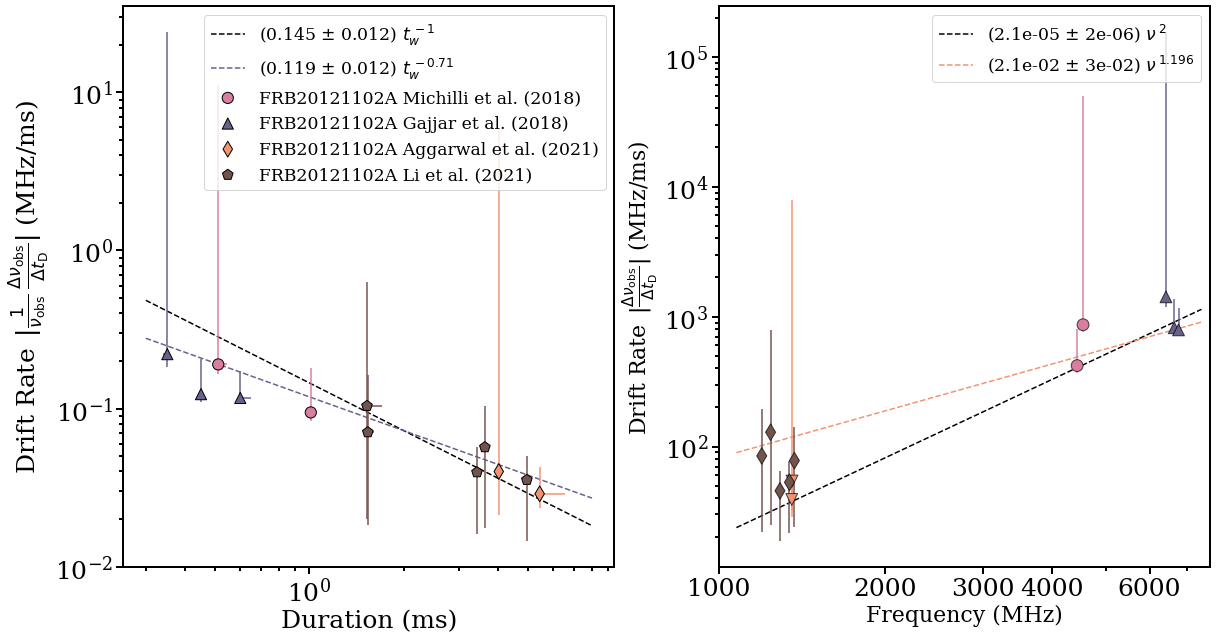

In [160]:
import importlib
importlib.reload(driftlaw)

driftdf = pd.read_csv('results/FRB121102_driftratesv2_922rows_Jul17.csv').set_index('name')
driftfig, driftaxs = plt.subplots(1, 2, figsize=(17, 9), facecolor='w')

baddrifts = [
    'B093', # drift = 0 
    'B032', # low snr
    'FRB121102_tracking-M01_0576', # positive, first burst has huge bandwidth and dominates the autocorrelation, not a drift rate
    'B109', # only fits to central feature
    'M013',
    'B071', #first burst band too big
    'FRB121102_tracking-M01_0163', # drift = 0
    'FRB121102_tracking-M01_0388', # not really a drift rate, fits to the brighter burst
    'FRB121102_tracking-M01_0415', # not a drift rate
    'FRB121102_tracking-M01_0630', # low snr
]
driftdf = driftdf.drop(baddrifts)
dfsbydataset = [
    driftdf[driftdf.index.str.startswith('M')],
    driftdf[driftdf.index.str.startswith('1')],
    driftdf[driftdf.index.str.startswith('B')],
    driftdf[driftdf.index.str.startswith('F')]
]
targetDMs = [556.5, 559.5, 560.0, 562.5]
bakeddata, fitdata, sources, extradata = driftlaw.bakeMeasurements(dfsbydataset, names[:2]+names[3:], [[],[],[],[]], targetDMs, logging=False, tagColors=tagColors[:2]+tagColors[3:])
print(f"target DMs: {driftlaw.getOptimalDMs(fitdata, log=False)}")

#### fig a
ax, _ = driftlaw.plotSlopeVsDuration(bakeddata['frames'], bakeddata['labels'], fitlines=['r-', 'r--', 'b--', 'g-.'], title=None, 
                                     annotatei=[], fitextents=[0.3, 8], hidefit=[0, 1, 2, 3], markers=['o', '^', 'd', 'p'],
                                     logscale=True, errorfunc=driftlaw.limitedDMrangeerror, fiterrorfunc=driftlaw.log_error, ax=driftaxs[0])
alldriftdfs = pd.concat(bakeddata['frames'])
fit = driftlaw.fitodr(alldriftdfs, errorfunc=driftlaw.log_error)
param, err = np.exp(fit.beta[0]), np.exp(fit.beta[0])*(np.exp(fit.sd_beta[0])-1)

# y = Ax^n; lny = nlnx + lnA
odrmodel = scipy.odr.Model(lambda B, x: B[1]*x + B[0])
odrdata = scipy.odr.RealData(np.log(alldriftdfs['tau_w_ms']), np.log(alldriftdfs['slope_over_nuobs']), sx=driftlaw.log_error(alldriftdfs)[0], sy=driftlaw.log_error(alldriftdfs)[1])
odrjob = scipy.odr.ODR(odrdata, odrmodel, beta0=[1, 1])
odrjob.set_job(fit_type=0)
odrfit = odrjob.run()
odrerror = np.exp(odrfit.beta[0]) * (np.exp(odrfit.sd_beta[0])-1)

tw = np.linspace(0.3, 8, num=1200)

ax.plot(tw, param/tw, color='k', ls='--', label=f'({param:.3f} $\pm$ {err:.3f}) $t_w^{{\,-1}}$', zorder=-2)
ax.plot(tw, np.exp(odrfit.beta[0])*tw**odrfit.beta[1], color=tagColors[1], ls='--', label=f'({np.exp(odrfit.beta[0]):.3f} $\pm$ {odrerror:.3f}) $t_w^{{\,{odrfit.beta[1]:.2f}}}$', zorder=-2)

ax.legend(fontsize='xx-large')
ax.set_ylabel('Drift Rate $\\,\\left|\\frac{1}{\\nu_\\mathrm{obs}}\,\\frac{\Delta\\nu_\\mathrm{obs}}{\Delta t_\\mathrm{D}}\\right|$ (MHz/ms)')
ax.set_xlabel('Duration (ms)')

#### fig b

eslope = lambda frame: [np.array([frame['slope_abs'] - frame['lim_slope_min'], frame['lim_slope_max'] - frame['slope_abs']])]
ylabel = 'Drift Rate $\\,\\left|\\frac{\Delta\\nu_\\mathrm{obs}}{\Delta t_\\mathrm{D}}\\right|$ (MHz/ms)'
ax = plotframes(bakeddata['frames'], 'center_f', 'slope_abs', xlabel="Frequency (MHz)", labels=None, ylabel=ylabel, logscale=True, yerrf=eslope, ax=driftaxs[1])

# linepo, pcov = scipy.optimize.curve_fit(lambda x, a: a*x, (alldriftdfs['center_f']), (alldriftdfs['slope_abs']), sigma=None, absolute_sigma=False)
# quadpo, pcov = scipy.optimize.curve_fit(lambda x, a: a*x**2, (alldriftdfs['center_f']), (alldriftdfs['slope_abs']), sigma=None, absolute_sigma=False)
# powerpo, pcov = scipy.optimize.curve_fit(lambda x, a, n: a+n*x, np.log10(alldriftdfs['center_f']), np.log10(alldriftdfs['slope_abs']), sigma=None, absolute_sigma=False, p0=[np.log10(1.8e-8), 1])
# print(powerpo)

# y = Ax^2
odrmodel = scipy.odr.Model(lambda B, x: B[0]*x**2)
sx = alldriftdfs['f_res (mhz)']/np.sqrt(12)
sy = np.sqrt(alldriftdfs['red_chisq'])*alldriftdfs['slope error (mhz/ms)']
# sy = np.maximum(*[alldriftdfs['slope_abs'] - alldriftdfs['lim_slope_min'], alldriftdfs['lim_slope_max'] - alldriftdfs['slope_abs']])
odrdata = scipy.odr.RealData(alldriftdfs['center_f'], alldriftdfs['slope_abs'], sx=sx, sy=sy)
odrjob = scipy.odr.ODR(odrdata, odrmodel, beta0=[1])
odrjob.set_job(fit_type=0)
odrfit = odrjob.run()
odrerror = odrfit.sd_beta[0]

# y = Ax^n
odrmodel = scipy.odr.Model(lambda B, x: B[0]*x**B[1])
sx = alldriftdfs['f_res (mhz)']/np.sqrt(12)
odrdata = scipy.odr.RealData(alldriftdfs['center_f'], alldriftdfs['slope_abs'], sx=sx, sy=np.maximum(driftlaw.rangeerror(alldriftdfs)[1][0][0], driftlaw.rangeerror(alldriftdfs)[1][0][1]))
odrjob = scipy.odr.ODR(odrdata, odrmodel, beta0=[1, 1])
odrjob.set_job(fit_type=0)
odrfit2 = odrjob.run()
odrerror2 = odrfit2.sd_beta[0]

fitextents = min(driftdf['center_f'])*0.9, max(driftdf['center_f'])*1.1
x = np.linspace(fitextents[0], fitextents[1], num=1200)

# ax.plot(x, (linepo[0])*x, 'k', linestyle='--', lw=2, label=f'${{{linepo[0]:.4f}}} x$')
# ax.plot(x, (quadpo[0])*x**2, 'b', linestyle='--', lw=2, label=f'${{{quadpo[0]:.4f}}} x^2$')
# ax.plot(x, 10**powerpo[0]*(x**powerpo[1]), 'b', linestyle='--', lw=2, label=f'${{{10**powerpo[0]:.2e}}} \cdot x^{{{powerpo[1]:.3f}}}$')

# x = np.linspace(1e3, 7.7e3)
ax.plot(x, odrfit.beta[0]*x**2, color='k', ls='--', label=f'({odrfit.beta[0]:.1e} $\pm$ {odrerror:.0e}) $\\nu^{{\,2}}$', zorder=-2)
ax.plot(x, odrfit2.beta[0]*x**odrfit2.beta[1], color=tagColors[3], ls='--', label=f'({odrfit2.beta[0]:.1e} $\pm$ {odrerror2:.0e}) $\\nu^{{\,{odrfit2.beta[1]:.3f}}}$', zorder=-2)


ax.legend(fontsize='xx-large')
ax.set_xlim(1000, 7700)
xticks = [1000, 2000, 3000, 4000, 6000]
ax.set_xticks(xticks)
ax.set_xticklabels(xticks)
plt.close()
driftfig.tight_layout()
driftfig.axes[0].tick_params(labelsize=25)
driftfig.axes[1].tick_params(labelsize=25)
driftfig.savefig(f'figures/Driftfigs_{datestr}.pdf')
driftfig

# Li Figures

In [426]:
# Load and Merge
burstpropertiesdf = pd.read_csv('data/li2019/FRB121102_1652burstListClean.csv').set_index("BurstID")
burstpropertiesdf['PulseID'] = [f"P{b:04}" for b in burstpropertiesdf.index]
burstpropertiesdf = burstpropertiesdf.reset_index().set_index("PulseID")
burstfilesdf      = pd.read_csv('data/li2019/PulseID_fileIDlist.csv', delimiter=';').set_index("Pulse_ID")
burstpropertiesdf = burstpropertiesdf.merge(burstfilesdf, left_index=True, right_index=True)

# Spreadsheet Cleanup
burstpropertiesdf[['DM', 'DM_d_error']] = burstpropertiesdf['DM'].str.split(r'\(\s*(\d*)\s*\)', expand=True)[[0,1]].astype('float64')
burstpropertiesdf[['Width(ms)', 'Width_d_error']] = burstpropertiesdf['Width(ms)'].str.split(r'\(\s*(\d*)\s*\)', expand=True)[[0,1]].astype('float64')
burstpropertiesdf[['Peak_Flux(mJy)', 'Flux_error']] = burstpropertiesdf['Peak_Flux(mJy)'].str.split(expand=True)[[0,2]].astype('float64')
burstpropertiesdf[['Fluence(Jy_ms)', 'Fluence_error']] = burstpropertiesdf['Fluence(Jy_ms)'].str.split(r'\(\s*(\d*)\s*\)', expand=True)[[0,1]].astype('float64')
energyvals = burstpropertiesdf['Energy(erg)'].str.split(expand=True)
# burstpropertiesdf['Energy(erg)'] = (energyvals[0]+'e' + energyvals[5]).astype('float64')
# burstpropertiesdf['Energy_d_error'] = energyvals[5].astype('float64')
# energyvals
# energyvals[2].astype('float64')

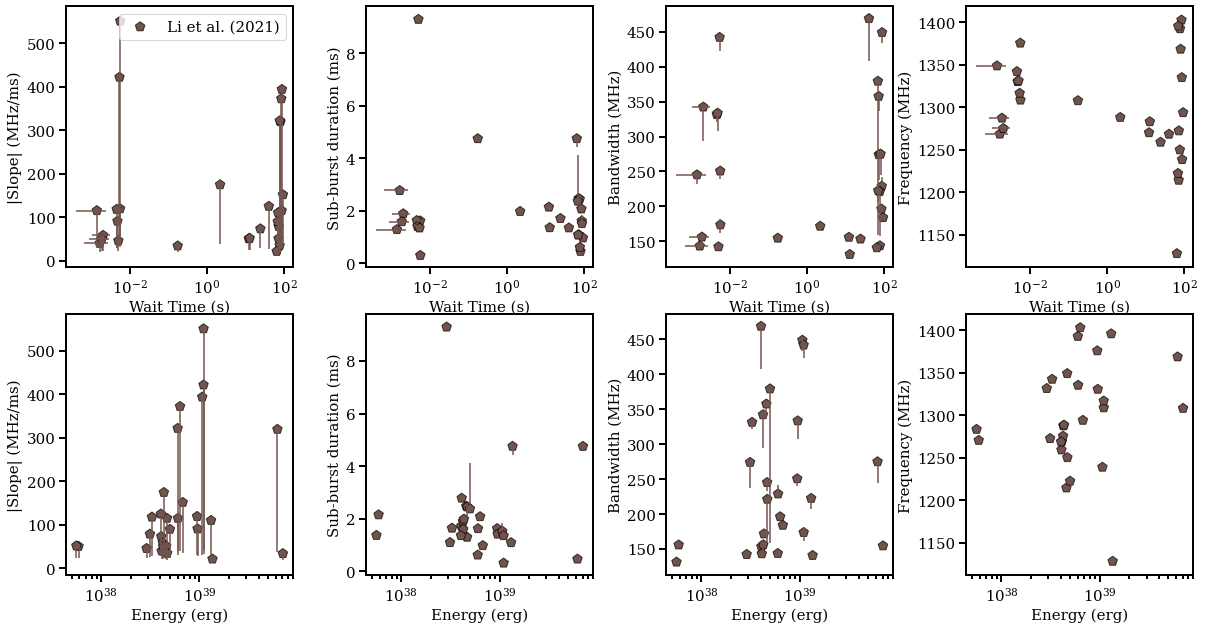

In [438]:
# Rows with nans are pulses we split up differently, and should be dropped
licombdf = pd.read_csv('data/li2019/licombined_Jul17_manual.csv').set_index('name')
licombdf['PulseID'] # 41 bursts - 13 nans = 28
licombdf = licombdf[licombdf['PulseID'].notna()]

figsize = (17, 9)
fontsize = 15
plt.rcParams.update({'font.size': fontsize})
lifig, liaxs = plt.subplots(2, 4, figsize=figsize, facecolor='w')
kwargs = {'figsize': figsize, 'c':'color', 'fontsize':fontsize, 'marker':'p', 'edgecolors':(0, 0, 0, 0.7), 'lw':1, 's':100}

# Shotgun correlations. Li columns: ['WaitTime(s)', 'log(WaitTime)', 'Energy(erg)', 'log(Energy)']
xlabel = 'Wait Time (s)'
eslope     = lambda frame: [np.array([frame['slope_abs'] - frame['lim_slope_min'], frame['lim_slope_max'] - frame['slope_abs']])]
eduration  = lambda f: driftlaw.limitedDMrangeerror(f)[0]
ebandwidth = lambda f: [np.array([f['bandwidth (mhz)'] - f['lim_band_min'], f['lim_band_max'] - f['bandwidth (mhz)']])]
efreq      = lambda f: f['f_res (mhz)']/np.sqrt(12)
licombdf.plot.scatter(**kwargs, ax=liaxs[0][0], x='WaitTime(s)', y='slope_abs',       logx=True, logy=False, xlabel=xlabel, ylabel='|Slope| (MHz/ms)',        xerr=0.001, yerr=eslope(licombdf), label='Li et al. (2021)',)
licombdf.plot.scatter(**kwargs, ax=liaxs[0][1], x='WaitTime(s)', y='tau_w_ms',        logx=True, logy=False, xlabel=xlabel, ylabel='Sub-burst duration (ms)', xerr=0.001, yerr=eduration(licombdf))
licombdf.plot.scatter(**kwargs, ax=liaxs[0][2], x='WaitTime(s)', y='bandwidth (mhz)', logx=True, logy=False, xlabel=xlabel, ylabel='Bandwidth (MHz)',         xerr=0.001, yerr=ebandwidth(licombdf))
licombdf.plot.scatter(**kwargs, ax=liaxs[0][3], x='WaitTime(s)', y='center_f',        logx=True, logy=False, xlabel=xlabel, ylabel='Frequency (MHz)',         xerr=0.001, yerr=efreq(licombdf))
liaxs[0][0].legend(loc='upper right')

xlabel = 'Energy (erg)'
xerr = 10**(licombdf['Energy_d_error']-2) # estimate, too small to see
licombdf.plot.scatter(**kwargs, ax=liaxs[1][0], x='Energy(erg)', y='slope_abs',       logx=True, logy=False, xlabel=xlabel, ylabel='|Slope| (MHz/ms)',        xerr=xerr, yerr=eslope(licombdf))
licombdf.plot.scatter(**kwargs, ax=liaxs[1][1], x='Energy(erg)', y='tau_w_ms',        logx=True, logy=False, xlabel=xlabel, ylabel='Sub-burst duration (ms)', xerr=xerr, yerr=eduration(licombdf))
licombdf.plot.scatter(**kwargs, ax=liaxs[1][2], x='Energy(erg)', y='bandwidth (mhz)', logx=True, logy=False, xlabel=xlabel, ylabel='Bandwidth (MHz)',         xerr=xerr, yerr=ebandwidth(licombdf))
licombdf.plot.scatter(**kwargs, ax=liaxs[1][3], x='Energy(erg)', y='center_f',        logx=True, logy=False, xlabel=xlabel, ylabel='Frequency (MHz)',         xerr=xerr, yerr=efreq(licombdf))

lifig.tight_layout(h_pad=0.01, w_pad=0.01)
# a = lifig.axes[0]
# a.get_xlabel().s
lifig.savefig(f'figures/LiCorrelations_{datestr}.pdf')

## Semi-Auto Combine

In [301]:
## Attempt a combine between my measurements and Li et al's measurements, however, since we disagree about the number of pulses in some waterfalls, it needs to be combined manually
lidf = bakeddata['frames'][-1]
dfnames = ['data/li2019/longbursts.csv', 'data/li2019/waittimesample.csv', 'data/li2019/peak1sample.csv', 'data/li2019/peak2sample.csv']
lipropsdf = pd.concat([pd.read_csv(dfname) for dfname in dfnames])
# lipropsdf.set_index('File_ID')
bursturls = np.load('/mnt/e/Li2021/scripts/bursturls.npy') # all available Li bursts

obsdates = lipropsdf['Obs_Date'].str.split('UT', expand=True)[1]
fileids = lipropsdf['File_ID']
filenames = []
dupes = {'FRB121102_tracking-M01_0576':0, 'FRB121102_tracking-M01_0133':0, 'FRB121102_tracking-M01_0118':0, 'FRB121102_tracking-M01_0112':0}
for obsdate, fileid in zip(obsdates, fileids):
    url = [url for url in bursturls if (obsdate in url) and (fileid in url)]
    if len(url) > 0:
        url = url[0]
    url = url.split('/')[-1].split('.')[0]
    if url in dupes:
        dupes[url] += 1
        url = f'{url}_{driftrate.subburst_suffixes[dupes[url]-1]}'
    filenames.append(url)
lipropsdf['name'] = filenames
lipropsdf = lipropsdf.set_index('name')
lipropsdf.to_csv('data/li2019/lipropsdf.csv')
lipropsdf

pd.concat([lidf, lipropsdf], axis=1).to_csv(f'data/li2019/licombined_{datestr}.csv')

# Measurement Example

figures/B006.pdf
plotting B006


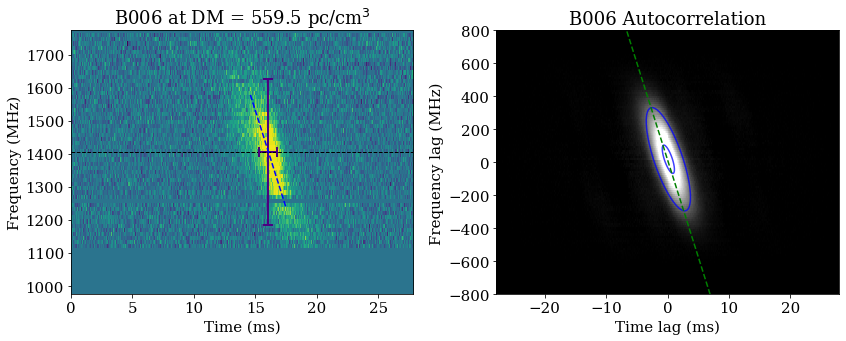

In [317]:
import glob
import matplotlib.pyplot as plt
importlib.reload(driftrate)
aggdf = pd.read_csv('results/FRB121102_aggarwal_4785rows_Jul07.csv').set_index('name')
DM = 559.5

resultsdf = aggdf.loc[(aggdf['DM'] == DM) & (aggdf.index == 'B006')]
datafiles = glob.glob('data/aggarwal2021/*.npz',)
masks = np.load('aggarwalmasks_Jun17_2022.npy', allow_pickle=True)[0]

plt.figure(figsize=(12, 5))
ploti = itertools.count(start=1, step=1)
outputfile = f"figures/B006.pdf"
print(outputfile)

nrows, ncols = 1, 2
pname = ''
for name, row in resultsdf.iterrows():
    if pname != name: print('plotting', name)  # print once
    pname = name
    ismulti = any([suffix in name[-2:] for suffix in driftrate.subburst_suffixes])
    if 'background' in row.index and not np.isnan(row['background']) and ismulti:
        subname = name
        name, suffix = '_'.join(name.split('_')[:-1]), name.split('_')[-1]
        regcols = [col for col in row.index if 'reg' in col]
        regcols.append('background') if 'background' in row.index else None
        regions = {suffix: [row[f'regstart_{suffix}'], row[f'regend_{suffix}']]}
        regions['background'] = [0, row['background']]
    else:
        regions = None

    file = [f for f in datafiles if name in f][0]
    data = np.load(file, allow_pickle=True)

    wfall = data['wfall']
    storedshape = wfall.shape

    df, dt_ms = row['f_res (mhz)'], row['time_res (s)']*1000
    lowest_freq = min(data['dfs']) # off by half a channel probably

    # apply masks
    if masks is not None and masks != []:
        mask = [masks[k] for k in masks.keys() if name in k]
        if mask != []:
            mask = mask[0]['chans']
        for m in mask:
            if m < len(wfall):
                wfall[m] = 0

    # Check if the waterfall was subsampled before measuring and subsample if so
    if 'downf' in row and 'downt' in row:
        wfall = driftrate.subsample(wfall, int(wfall.shape[0]/row['downf']), int(wfall.shape[1]/row['downt']))
    if 'tsamp_width' in row:
        wfall = driftrate.cropwfall(wfall, twidth=row['tsamp_width']) # crop after subsampling.

    if 'subbg_start (ms)' in row and not np.isnan(row['subbg_start (ms)']):
        tleft, tright = row['subbg_start (ms)'], row['subbg_end (ms)']
        timerange = [0, round(dt_ms*wfall.shape[1])]
        tleft  = round(np.interp(tleft, timerange, [0, wfall.shape[1]]))
        tright = round(np.interp(tright, timerange, [0, wfall.shape[1]]))
        wfall = driftrate.subtractbg(wfall, tleft, tright)

    extents, corrextents = driftrate.getExtents(wfall, df=df, dt=dt_ms, lowest_freq=lowest_freq)
    if regions:
        wfall = driftrate.getSubbursts(wfall, df, dt_ms, lowest_freq, regions)[suffix]
        extents, corrextents = driftrate.getExtents(wfall, df=df, dt=dt_ms, lowest_freq=lowest_freq)

    # dedisperse
    ddm = row['DM'] - data['DM']
    wfall = driftrate.dedisperse(wfall, ddm, lowest_freq, df, dt_ms)

    corr = driftrate.autocorr2d(wfall)
    popt = [row['amplitude'], row['xo'], row['yo'], row['sigmax'], row['sigmay'], row['angle']]

    fitmap = driftrate.makeDataFitmap(popt, corr, corrextents)

    currentplot = next(ploti)
    bname = name if not regions else subname
    aspect = 'auto'

    plt.subplot(nrows, ncols, currentplot)
    # print(f"{df/dt_ms = } {wfall.shape[0]/wfall.shape[1] = } {corr.shape[0]/corr.shape[1] = }")
    plt.imshow(wfall, origin='lower', interpolation='none', aspect=aspect, extent=extents)
    plt.axhline(y=row['center_f'], c='k', ls='--', lw=1)
    if popt[0] > 0:
        # add duration and slope markers to waterfall
        pkidx = np.nanargmax(np.nanmean(wfall, axis=0))
        plt.errorbar(pkidx*dt_ms, row['center_f'],
            xerr=row['tau_w_ms']/2, yerr=row['bandwidth (mhz)']/2,
            color='#4b0082', linewidth=2, capthick=2, capsize=5, fmt='none')
        xo = pkidx*dt_ms
        x = np.array([xo - row['tau_w_ms'], xo + row['tau_w_ms']])
        plt.plot(x, row['slope (mhz/ms)']*x + row['center_f'] - row['slope (mhz/ms)']*xo, 'b--', lw=1.5)
        plt.xlim(extents[:2]); plt.ylim(extents[2:])
    plt.title(f'{bname} at DM = {round(row["DM"], 2)} pc/cm$^3$')
    plt.xlabel('Time (ms)'), plt.ylabel('Frequency (MHz)')

    currentplot = next(ploti)
    plt.subplot(nrows, ncols, currentplot)
    plt.imshow(corr, origin='lower', interpolation='none', aspect=aspect, cmap='gray', extent=corrextents)
    plt.clim(0, np.max(corr)/3)
    plt.title(f'B006 Autocorrelation')
    plt.xlabel('Time lag (ms)'), plt.ylabel('Frequency lag (MHz)')
    if popt[0] > 0:
        plt.contour(fitmap, [popt[0]/4, popt[0]*0.9], colors='b', alpha=0.75, extent=corrextents)
        # plt.contour(fitmap, [popt[0]/2, popt[0]/np.sqrt(np.e)], colors='b', alpha=0.75, extent=corrextents)
        # find and display snr
        a = round(np.interp(popt[1]-popt[3], [corrextents[0], corrextents[1]], [0, corr.shape[1]]))
        b = round(np.interp(popt[1]+popt[3], [corrextents[0], corrextents[1]], [0, corr.shape[1]]))
        c = round(np.interp(popt[2]-popt[4], [corrextents[2], corrextents[3]], [0, corr.shape[0]]))
        d = round(np.interp(popt[2]+popt[4], [corrextents[2], corrextents[3]], [0, corr.shape[0]]))

        # snr = abs(corr[c:d, a:b].sum() / corr[0:(d-c), 0:(b-a)].sum())
        # snr = 2*popt[0]*(1-np.exp(-1/2)) / (corr[0:(d-c), 0:(b-a)].sum() / ((d-c)*(b-a)))
        snr = abs(2*popt[0]*(1-np.exp(-1/2)) / (corr[0:(d-c), 0:(b-a)].sum() / (4*popt[4]*popt[3])))
        # if snr < 100000:
        #     plt.text(corrextents[0]*0.95, corrextents[2]*0.95, f"snr: {snr:.1f}", color='w')
        # else:
        #     plt.text(corrextents[0]*0.95, corrextents[2]*0.95, f"snr: > 100000", color='w')

        # plot line of corresponding slope
        xo, yo = row['xo'], row['yo']
        slope = row['slope (mhz/ms)']
        x = np.array([corrextents[2] / slope + xo, corrextents[3] / slope + xo])
        plt.plot(x, slope*(x-xo), 'g--', lw=1.5)
        plt.xlim(corrextents[:2]); plt.ylim(corrextents[2:])

plt.tight_layout()
# plt.savefig(outputfile)

# Data Space vs Channel Space Measurements

results/FRB121102_aggarwal_results_1078rows_Dec08.csv
results/FRB121102_aggarwal_results_1122rows_Jan14.csv


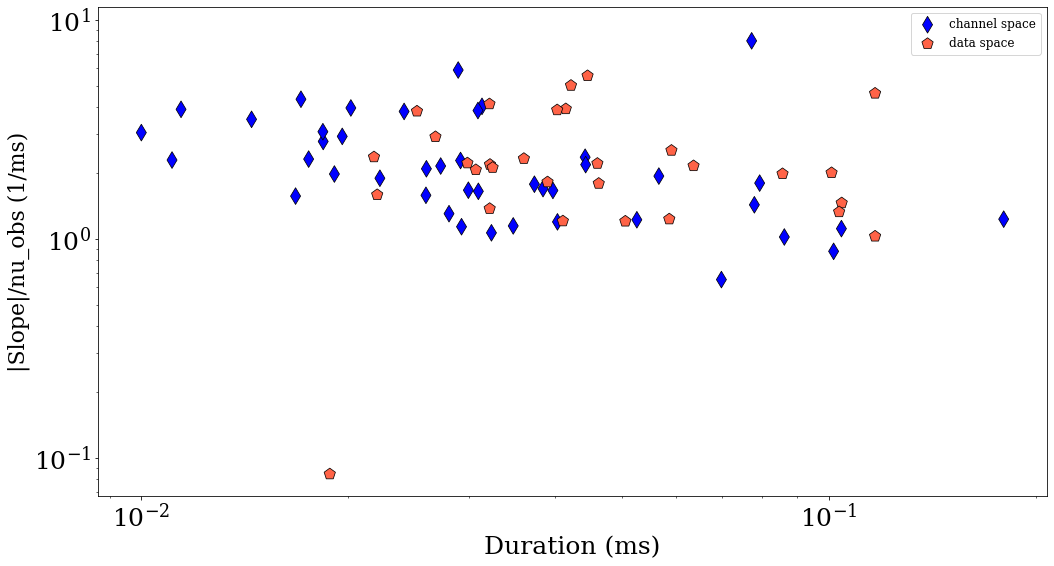

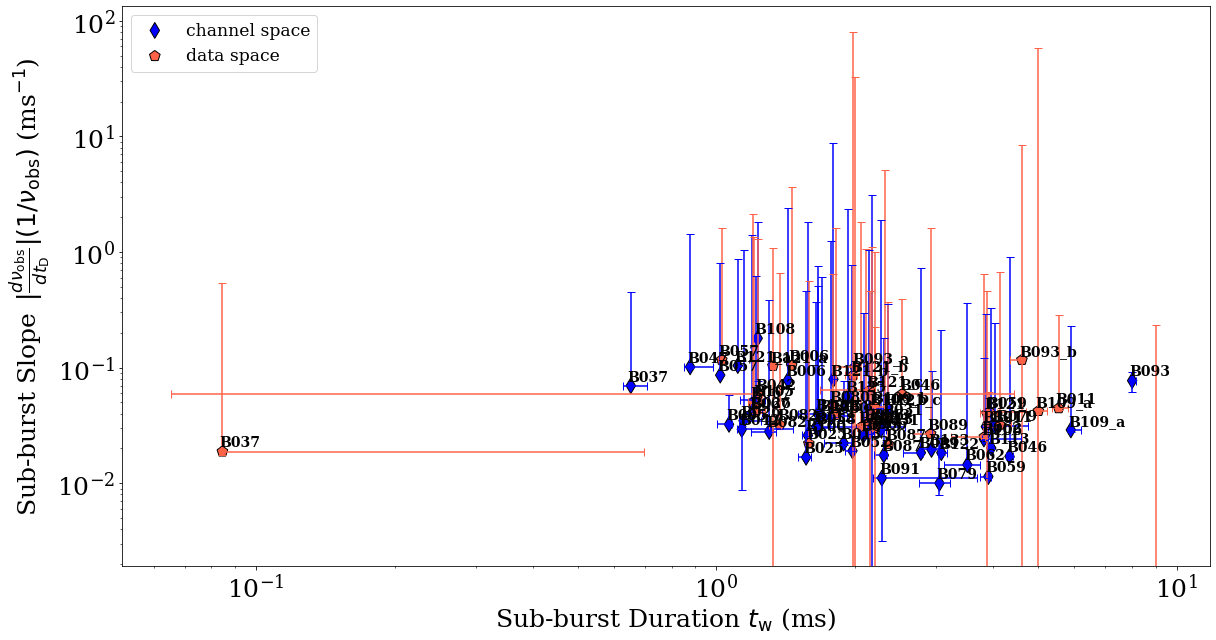

In [32]:
importlib.reload(driftlaw)
%matplotlib inline
filenames = [
    'results/FRB121102_aggarwal_results_1078rows_Dec08.csv',
    'results/FRB121102_aggarwal_results_1122rows_Jan14.csv',
]
agg_measurments = []
colors = itertools.cycle(['b', 'tomato', 'c'])
targetDM = 560
for sfile in filenames:
    df = pd.read_csv(sfile)
    df = df.set_index("name")
    
    ## Burst Exclusions
    df = df.drop(['B023', 'B016', 'B028', 'B056', 'B109'])
    df = df[df.amplitude > 0]
    df = df[df.slope_abs > 0] 
    relerrthreshold = 0.4 # (40%)
    df = df[abs(df['slope error (mhz/ms)']/df['slope (mhz/ms)']) < relerrthreshold]
    errorthreshold = 1e8
    df = df[df['slope error (mhz/ms)'] < errorthreshold] 
    
    df = driftlaw.computeModelDetails(df)
    if 'Dec08' in sfile:
        df['tau_w_ms'] = df['tau_w_ms_old']
    df = driftlaw.sloperanges(df) # compute drift ranges after burst exclusions
    df = df[np.isclose(df.DM, targetDM)]
    print(sfile)
    df['color'] = next(colors)

    agg_measurments.append(df)
    
labels = ['channel space', 'data space']
ax = plotframes(agg_measurments, 'slope_over_nuobs', 'tau_w_ms', xlabel="Duration (ms)", ylabel="|Slope|/nu_obs (1/ms)", 
                figsize=(17, 9), labels=labels,
                logscale=True)# yerrf=lambda f: driftlaw.rangeerror(f)[1])

annotatei = [0,1]
ax, _ = driftlaw.plotSlopeVsDuration(agg_measurments, labels, fitlines=['r-', 'r--', 'b--', 'g-.'], markers=['d', 'p'], title=None, 
                                     annotatei=annotatei, fitextents=[0.0728, 15], hidefit=[0, 1],
                                     logscale=True, errorfunc=driftlaw.rangeerror, fiterrorfunc=driftlaw.log_error)


# Drift vs. Frequency (Discussion Figure)
chamma et al. 2021

In [4]:
Bfits = np.array(Bconstants)
print(Bfits[:,0].min(), Bfits[:,0].max())
Bfits

<ipython-input-4-18217543ed36>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Bfits = np.array(Bconstants)


2.078964601744387e-08 3.501656829509886e-06


array([[3.755319457097987e-08, array([4.62947829e-09])],
       [3.958180525027664e-08, array([5.0959902e-09])],
       [4.186004466660003e-08, array([5.6489454e-09])],
       [4.5082972650862676e-08, array([6.80620332e-09])],
       [4.758091700090433e-08, array([7.14720958e-09])],
       [5.124433656779428e-08, array([8.19180507e-09])],
       [5.550334322804194e-08, array([9.5303914e-09])],
       [6.056955240732434e-08, array([1.12315229e-08])],
       [6.741532716456259e-08, array([1.37664844e-08])],
       [7.603638541932202e-08, array([1.74761348e-08])],
       [9.068450727638977e-08, array([2.44005783e-08])],
       [1.1731959437042582e-07, array([4.16298612e-08])],
       [2.3694669910297258e-07, array([1.44999377e-07])],
       [1.2132157911508368e-07, array([4.03948839e-08])],
       [1.7911307842075265e-07, array([7.9283062e-08])],
       [1.5651949767466468e-07, array([7.17765978e-08])],
       [3.501656829509886e-06, array([3.38884067e-06])],
       [2.1501480077554237e-0

6.590426024179991e-08 8.446693232174064e-09


<ipython-input-7-a5f2cb9c7565>:81: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Bfits = np.array(Bconstants)


2.078964601744387e-08 3.501656829509886e-06


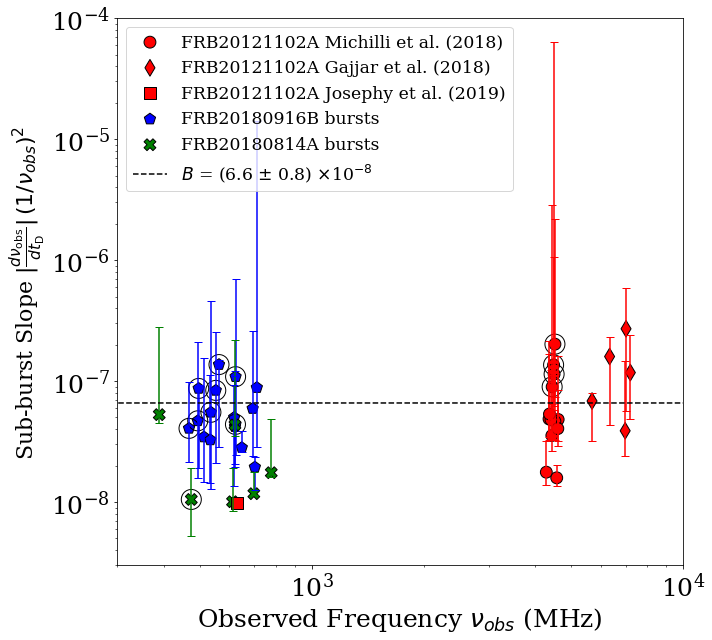

In [7]:
%matplotlib inline
def drift_nuobs_expr(B, x):
    return B[0]*x**2

def drift_nuobs_expr_log(B, x):
    return B[0] + 2*x

def constantmodel(x, c):
    return c

def drift_nuobs_sq(B, x):
    return B[0]*np.ones(x.shape)

def frexp10(x):
    """ 
    source : github.com/joelfrederico/SciSalt/blob/master/scisalt/numpy/frexp10.py 
    related: stackoverflow.com/questions/45332056/decompose-a-float-into-mantissa-and-exponent-in-base-10-without-strings 
    """
    expon = np.int(np.floor(np.log10(np.abs(x))))
    mant = x/np.power(10.0, expon)
    return (mant, expon)

plt.rcParams["errorbar.capsize"] = 4
plt.rcParams["font.family"] = "serif"

markersize = 140
fontsize = 25
annotsize = 14
logscale = True
figsize = (10, 9)

frames = fig1pltdata['frames']
for frame in frames: 
    frame['drift_abs_nuobssq'] = frame['drift_abs']/frame['center_f']**2/1000
    
def yerror(frame):
    """ the shape of this is (1, 2, len(frame)) because pandas """
    ey = [np.array([frame['drift_abs_nuobssq'] - frame['drift_nu_min']/frame['center_f']/1000, frame['drift_nu_max']/frame['center_f']/1000 - frame['drift_abs_nuobssq']])]
    return ey

ax = frames[0].plot.scatter(x='center_f', y='drift_abs_nuobssq', 
                           # yerr=np.sqrt(frames[0]['red_chisq'])*frames[0]['drift error (mhz/ms)']*(1/frames[0]['center_f']**2)/1000,
                           yerr=yerror(frames[0]),
                           figsize=figsize, s=markersize, c='color', 
                           colorbar=False, fontsize=fontsize, 
                           logy=logscale, logx=logscale, marker='o', edgecolors='k',
                           label='FRB20121102A Michilli et al. (2018)')

labels = ['FRB20121102A Gajjar et al. (2018)', 'FRB20180916B bursts', 'FRB20180814A bursts']
for frame, label, mark in zip(frames[1:], labels, ['d', 'p', 'X']):
    frame.plot.scatter(ax=ax, x='center_f', y='drift_abs_nuobssq', 
                       # yerr=np.sqrt(frame['red_chisq'])*frame['drift error (mhz/ms)']*(1/frame['center_f']**2)/1000,
                       yerr=yerror(frame),
                       figsize=figsize, s=markersize, c='color', colorbar=False, 
                       fontsize=fontsize, logy=logscale, logx=logscale, marker=mark, edgecolors='k',
                       label=label)

# Josephy point
ax.scatter(josephyburst['center_f'], -josephyburst['drift (mhz/ms)']/josephyburst['center_f']**2/1000, c='r', s=125, edgecolors='k', marker='s', label='FRB20121102A Josephy et al. (2019)')

## Mark all bursts whose DM ranges were limited by the exclusion process
for i, limitedpoints in enumerate(dmlimited):
    for lp in limitedpoints:
        v = fig1pltdata['frames'][i].loc[lp]
        plt.scatter(v['center_f'], v['drift_abs_nuobssq'], facecolors='none', edgecolors='k', linewidth=1.0, s=400)
        # ax.annotate('o', (v['tau_w_ms'], v['drift_over_nuobs']), xytext=(-10,-18), textcoords='offset pixels', weight='bold', size=25)

ax.set_xlabel('Observed Frequency $\\nu_{obs}$ (MHz)', size=fontsize)
ax.set_ylabel('Sub-burst Slope $\left|\\frac{d\\nu_\\mathrm{obs}}{dt_\\mathrm{D}}\\right|\, (1/\\nu_{obs})^{2}$', size=fontsize-3)
alldata = pd.concat([f for f in fig1pltdata['frames']])#+[josephyburst]])

x = np.linspace(0, 20000, num=2000)   
popt, pcov = scipy.optimize.curve_fit(lambda x, c: c, x, alldata['drift_abs_nuobssq'])
berr = frexp10(np.sqrt(pcov[0][0]))[0]
hacklbl = f'$\it{{B}}$ = ({frexp10(popt[0])[0]:.2} $\pm$ {berr/10:.1}) $\\times$10$^{{{frexp10(popt[0])[1]}}}$'
# hacklbl = '($B = 6.7 \\times 10^{-8}$)'
plt.plot(x, popt[0]*np.ones(x.shape), 'k--', label=hacklbl)
print(popt[0], np.sqrt(pcov[0][0]))#, np.frexp(popt[0]))

# range of fits
Bfits = np.array(Bconstants)
color = 'b'
bmin, bmax = Bfits[:,0].min(), Bfits[:,0].max()
print(bmin, bmax)
lstr = f"Range of fits: {frexp10(bmin)[0]:.2}$\\times$10$^{{{frexp10(bmin)[1]}}}$ to {frexp10(bmax)[0]:.2}$\\times$10$^{{{frexp10(bmax)[1]}}}$"
lstr = "Range of possible fits"
# lstr = f"Range of fits {Bfits[:,0].min():.1e} - {Bfits[:,0].max():.1e}"
# ax.fill_between(x, Bfits[:,0].min(), Bfits[:,0].max(), alpha=0.1, color=color, edgecolor=color, label=lstr, zorder=-10)

hdls, lbls = ax.get_legend_handles_labels()
order = [1, 2, 5, 3, 4, 0]
hdls = [hdls[i] for i in order]
lbls = [lbls[i] for i in order]
ax.legend(hdls, lbls, fontsize='xx-large', loc=2)

plt.xlim(3*10**2, 10**4)
plt.ylim(0.3*10**-8, 1*10**-4)
plt.tight_layout()
plt.savefig('universal/driftvsnuobs_log.pdf')

Text(0.5, 0, 'Observed Frequency (MHz)')

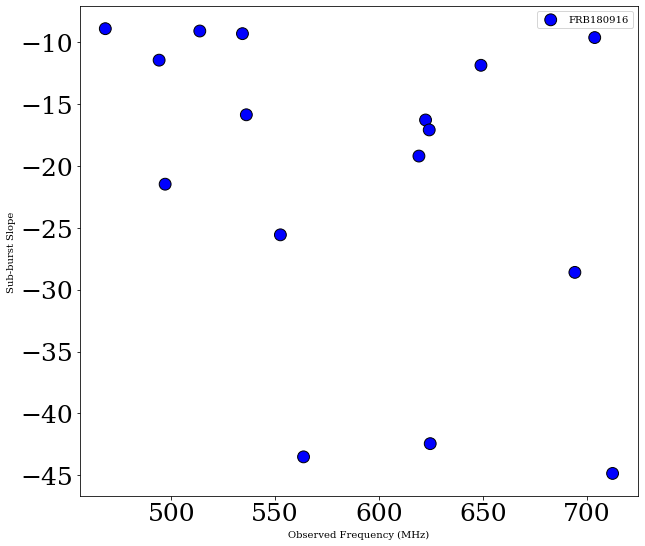

In [7]:
# sub-burst slope vs nu_obs to compare with pastor-marazuela et al. 2020
ax = frames[2].plot.scatter(x='center_f', y='drift (mhz/ms)', 
                           # yerr=np.sqrt(frames[0]['red_chisq'])*frames[0]['drift error (mhz/ms)']*(1/frames[0]['center_f']**2)/1000,
                           yerr=yerror(frames[2]),
                           figsize=figsize, s=markersize, c='color', 
                           colorbar=False, fontsize=fontsize, 
                           logy=False, logx=False, marker='o', edgecolors='k',
                           label='FRB180916')
ax.set_ylabel("Sub-burst Slope")
ax.set_xlabel("Observed Frequency (MHz)")

# Reference

<ipython-input-31-166b622dec7b>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  michillibursts['drift_abs_z'] = michillibursts['drift_abs']*(1+michillibursts['z'])**2
<ipython-input-31-166b622dec7b>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  michillibursts['drift_abs_nuobssq'] = michillibursts['drift_abs']*(1/michillibursts['center_f']**2)/1000
<ipython-input-31-166b622dec7b>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

[8.22364449e-08] [1.73154499e-08]
[8.22364445e-08] [1.731545e-08]


<ipython-input-31-166b622dec7b>:112: RuntimeWarning: divide by zero encountered in log
  xlog = np.log(x)


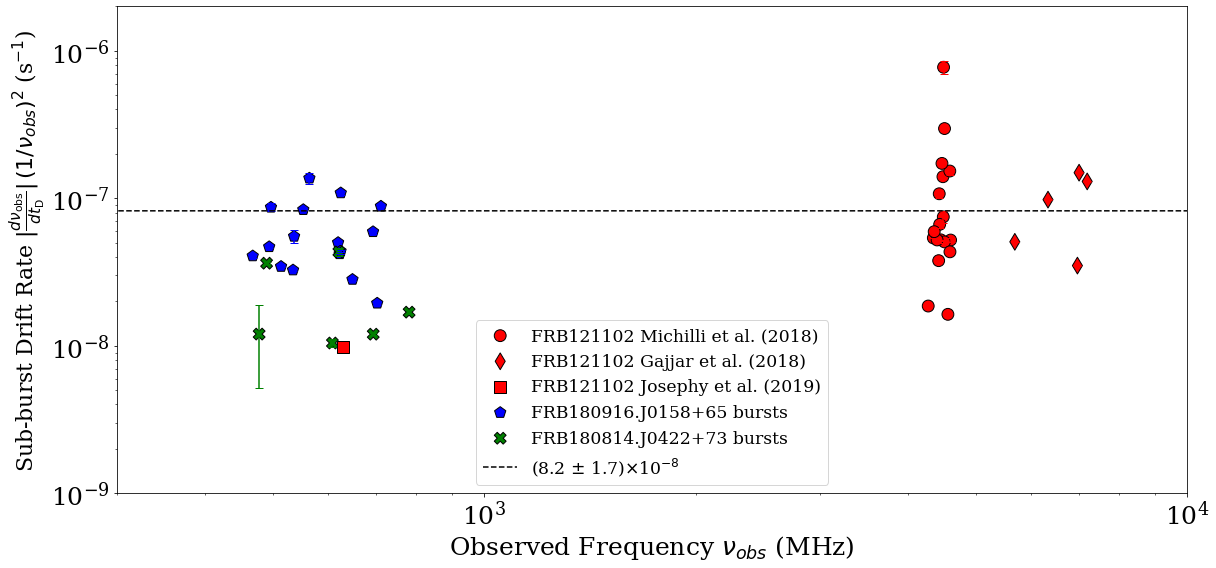

In [31]:
# michili fit
def drift_nuobs_expr(B, x):
    return B[0]*x**2

def drift_nuobs_expr_log(B, x):
    return B[0] + 2*x

def constantmodel(x, c):
    return c

def drift_nuobs_sq(B, x):
    return B[0]*np.ones(x.shape)

drift_nuobs_model = scipy.odr.Model(drift_nuobs_expr)
drift_nuobs_model_log = scipy.odr.Model(drift_nuobs_expr_log)
drift_nuobs_sq_model = scipy.odr.Model(drift_nuobs_sq)

plt.rcParams["errorbar.capsize"] = 4
plt.rcParams["font.family"] = "serif"

markersize = 140
fontsize = 25
annotsize = 14
logscale = True
filename = 'log_drift_over_nu_obsvsduration_inprep' if logscale else 'drift_over_nu_obsvsduration_inprep'
figsize = (17, 8)
# figsize = (14, 10)

michillibursts['drift_abs_z'] = michillibursts['drift_abs']*(1+michillibursts['z'])**2
michillibursts['drift_abs_nuobssq'] = michillibursts['drift_abs']*(1/michillibursts['center_f']**2)/1000
michillibursts['center_f_z'] = michillibursts['center_f']*(1+michillibursts['z'])

selectbursts180916['drift_abs_z'] = selectbursts180916['drift_abs']*(1+selectbursts180916['z'])**2
selectbursts180916['drift_abs_nuobssq'] = selectbursts180916['drift_abs']*(1/selectbursts180916['center_f']**2)/1000
selectbursts180916['center_f_z'] = selectbursts180916['center_f']*(1+selectbursts180916['z'])

selectbursts180814['drift_abs_z'] = selectbursts180814['drift_abs']*(1+selectbursts180814['z'])**2
selectbursts180814['drift_abs_nuobssq'] = selectbursts180814['drift_abs']*(1/selectbursts180814['center_f']**2)/1000
selectbursts180814['center_f_z'] = selectbursts180814['center_f']*(1+selectbursts180814['z'])

otherbursts['drift_abs_z'] = otherbursts['drift_abs']*(1+otherbursts['z'])**2
otherbursts['drift_abs_nuobssq'] = otherbursts['drift_abs']*(1/otherbursts['center_f']**2)/1000
otherbursts['center_f_z'] = otherbursts['center_f']*(1+otherbursts['z'])

ax = michillibursts.plot.scatter(x='center_f', y='drift_abs_nuobssq', 
                               yerr=np.sqrt(michillibursts['red_chisq'])*michillibursts['drift error (mhz/ms)']*(1/michillibursts['center_f']**2)/1000,
                               figsize=figsize, s=markersize, c='color', colorbar=False, fontsize=fontsize, logy=logscale, logx=logscale, marker='o', edgecolors='k',
                               label='FRB121102 Michilli et al. (2018)')
    
selectbursts180916.plot.scatter(ax=ax, x='center_f', y='drift_abs_nuobssq', 
                               yerr=np.sqrt(selectbursts180916['red_chisq'])*selectbursts180916['drift error (mhz/ms)']*(1/selectbursts180916['center_f']**2)/1000,
                               figsize=figsize, s=markersize, c='color', colorbar=False, fontsize=fontsize, logy=logscale, logx=logscale, marker='p', edgecolors='k',
                               label='FRB180916.J0158+65 bursts')
selectbursts180814.plot.scatter(ax=ax, x='center_f', y='drift_abs_nuobssq', 
                               yerr=np.sqrt(selectbursts180814['red_chisq'])*selectbursts180814['drift error (mhz/ms)']*(1/selectbursts180814['center_f']**2)/1000,
                               figsize=figsize, s=markersize, c='color', colorbar=False, fontsize=fontsize, logy=logscale, logx=logscale, marker='X', edgecolors='k',
                               label='FRB180814.J0422+73 bursts')

otherbursts.head(5).plot.scatter(ax=ax, x='center_f', y='drift_abs_nuobssq',
                         yerr=np.sqrt(otherbursts['red_chisq'])*otherbursts['drift error (mhz/ms)']*(1/otherbursts['center_f']**2)/1000,
                         figsize=figsize, s=markersize, c='color', colorbar=False, marker='d', edgecolors='k', label='FRB121102 Gajjar et al. (2018)')
otherbursts.tail(1).plot.scatter(ax=ax, x='center_f', y='drift_abs_nuobssq',
                         yerr=np.sqrt(otherbursts['red_chisq'])*otherbursts['drift error (mhz/ms)']*(1/otherbursts['center_f']**2)/1000,
                         figsize=figsize, s=markersize, c='color', colorbar=False, marker='s', edgecolors='k', label='FRB121102 Josephy et al. (2019)')

# for k, v in otherbursts.iterrows():
#     ax.annotate(k+'_c', (v['tau_w_ms_corr'], v['drift_corr']), xytext=(-3,5), textcoords='offset points', weight='bold', size=annotsize)
# for k, v in michillibursts.iterrows():
#     ax.annotate(k, (v['tau_w_ms'], v['drift_abs']), xytext=(-3,5), textcoords='offset points', weight='bold', size=annotsize)
# for k, v in selectbursts180916.iterrows():
#     ax.annotate(int(k) if k != 15.5 else k, (v['tau_w_ms'], v['drift_over_nuobs']), xytext=(-3,5), textcoords='offset points', weight='bold', size=annotsize)
# for k, v in selectbursts180814.iterrows():
#     if v['drift_abs'] > 0:
#         ax.annotate(k, (v['center_f'], v['drift_abs']), xytext=(-3,5), textcoords='offset points', weight='bold', size=annotsize)

# if not logscale:
#     ax.set_xlim(-0.1, 20)
#     ax.set_ylim(-0.2, 4)
# elif logscale:
#     ax.set_xlim(0.02, 50)
#     ax.set_ylim(10**-3, 10**1)

# ax.set_title('Sub-burst Drift Rate vs. Burst Duration (fit to Michilli bursts)', size=fontsize)
ax.set_xlabel('Observed Frequency $\\nu_{obs}$ (MHz)', size=fontsize)
ax.set_ylabel('Sub-burst Drift Rate $\left|\\frac{d\\nu_\\mathrm{obs}}{dt_\\mathrm{D}}\\right|\, (1/\\nu_{obs})^{2}$ (s$^{-1}$)', size=fontsize-3)


allbursts = pd.concat([michillibursts, otherbursts, selectbursts180916, selectbursts180814])
### LINEAR FIT
fitbitch = scipy.odr.RealData(allbursts['center_f'], 
                             allbursts['drift_abs_nuobssq'])#,
                             #sy=np.sqrt(allbursts['red_chisq'])*allbursts['drift error (mhz/ms)']*(1/allbursts['center_f']**2)/1000,
                             #sx=np.array(len(allbursts['center_f'])*[5000])*np.random.rand(len(allbursts['center_f'])))
fitter_driftnuobs = scipy.odr.ODR(fitbitch, drift_nuobs_sq_model, beta0=[0.00003])
fitter_driftnuobs.set_job(fit_type=0)
fitdriftnuobs = fitter_driftnuobs.run()

### LOG FIT
# fitbitch = scipy.odr.RealData(np.log(allbursts['center_f']), 
#                              np.log(allbursts['drift_abs']))
#                              #sy=np.log(np.sqrt(allbursts['red_chisq'])*allbursts['drift error (mhz/ms)']))
# fitter_driftnuobs = scipy.odr.ODR(fitbitch, drift_nuobs_model_log, beta0=[1000])
# fitter_driftnuobs.set_job(fit_type=0)
# fitdriftnuobs = fitter_driftnuobs.run()

x = np.linspace(0, 20000, num=2000)   
popt, pcov = scipy.optimize.curve_fit(constantmodel, x, allbursts['drift_abs_nuobssq'])#, 
                                      #sigma=np.sqrt(allbursts['red_chisq'])*allbursts['drift error (mhz/ms)']*(1/allbursts['center_f']**2)/1000, 
                                      #absolute_sigma=True)
print(popt, np.sqrt(pcov)[0])
### Plot fits
xlog = np.log(x)
print(fitdriftnuobs.beta, fitdriftnuobs.sd_beta)

hacklbl = '(8.2 $\pm$ 1.7)$\\times$10$^{-8}$'
lbl = '({:.1e} $\pm$ {:0.2e})'.format(fitdriftnuobs.beta[0], fitdriftnuobs.sd_beta[0])
#plt.plot(x, fitdriftnuobs.beta[0]*np.ones(x.shape), 'k--', label=hacklbl)
# plt.plot(x, fitdriftnuobs.beta[0]*np.ones(x.shape), 'k--', label=hacklbl)
plt.plot(x, popt[0]*np.ones(x.shape), 'k--', label=hacklbl)
#plt.plot(x, fitdriftnuobs.beta[0]+2*x, l, label=str((round(fitdriftnuobs.beta[0], 6))) + ' $\\nu_{obs}^{2}$')

# plt.xlim(2*10**2, 1*10**4)
# plt.ylim(10**-1, 10**5)
# plt.xlim(0, 10000); plt.ylim(-500, 20000)
handles, labels = ax.get_legend_handles_labels()
handles = [handles[1], handles[4], handles[5], handles[2], handles[3], handles[0]]
labels = [labels[1], labels[4], labels[5], labels[2], labels[3], labels[0]]
plt.legend(handles, labels, fontsize='xx-large', loc=8)

###
plt.xlim(3*10**2, 10**4)
plt.ylim(10**-9, 2*10**-6)

# plt.title("Non Redshift Corrected", size=20)
#plt.title("FRB121102, FRB180916.J0158+65, and FRB180814.J0422+73", size=20)
plt.tight_layout()
# plt.savefig('driftvsnuobs_log.pdf')

# Pasted from other notebook, dont run

In [ ]:
import numpy as np
import scipy.stats
import scipy.odr
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
from tqdm import tqdm
import functools
print = functools.partial(print, flush=True) # print doesn't happen til script ends so force it to flush... windows thing?
import pandas as pd
import driftlaw

bursts121102 = pd.read_csv('data/aggregate/burstsFRB121102.csv') 
bursts121102 = bursts121102.set_index('name')
##########
bursts180916 = pd.read_csv('data/aggregate/burstsFRB180916.csv') 
bursts180916 = bursts180916.set_index('name')
bursts180916['time_res'] = 0.00098304 # s
#########
bursts180814 = pd.read_csv('data/aggregate/burstsFRB180814.csv') # DM = 188.9 pc/cm3
bursts180814 = bursts180814.set_index('name')
bursts180814['time_res'] = 0.00098304 # s, Not true for burst 180917
###########
burstsSGR1935 = pd.read_csv('data/aggregate/SGR1935+2154bursts.csv')
burstsSGR1935 = burstsSGR1935.set_index('name')
##########

# Set redshifts
bursts121102['z']  = 0.19273 # (josephy et al. 2019, frbcat.org)
bursts180916['z']  = 0.0337  # (chime 2020b et al.)
bursts180814['z']  = 0.05    # not accurate, z < 0.1 (amiri et al. 2019)
burstsSGR1935['z'] = 0       # ? galactic

#######
bursts121102 = driftlaw.computeModelDetails(bursts121102)
bursts121102.at['C1', 'tau_w_ms'] = 11.4
bursts121102.at['C1', 'tau_w'] = 11.4/1000
bursts121102.at['C1', 'tau_w_error'] = 0.12
bursts121102_to_include = ['M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9a', 'M9b', 'M10a', 'M10b', 'M11', 'M12', 'M13', 'M14', 'M15', 'M16', 'G11D', 'G11A1a', 'G11A1b', 'G11A2', 'G11A3', 'C1']
selectbursts121102 = bursts121102.loc[bursts121102_to_include]

bursts180916 = driftlaw.computeModelDetails(bursts180916)
selectbursts180916 = bursts180916

bursts180814 = driftlaw.computeModelDetails(bursts180814)
selectbursts180814 = bursts180814.drop(180917)

burstsSGR1935 = driftlaw.computeModelDetails(burstsSGR1935)
#display(bursts121102[['tau_w', 'tau_w_error']], bursts180916[['tau_w', 'tau_w_error']], bursts180814[['tau_w', 'tau_w_error']], burstsSGR1935[['tau_w', 'tau_w_error']])

In [ ]:
fit_model = scipy.odr.Model(driftlaw.reciprocal_odr)
fit_model_log = scipy.odr.Model(driftlaw.reciprocal_odr_log)
# Color by source
selectbursts121102['color'] = 'r'#'c'
selectbursts121102.at[selectbursts121102.index > 'M', 'color'] = 'r'
selectbursts121102.at['C1', 'color'] = 'r'#'b'
selectbursts180916['color']          = 'b'
selectbursts180814['color']          = 'g'
burstsSGR1935['color']               = 'k'
michillibursts = selectbursts121102.head(18)
otherbursts = selectbursts121102.tail(6)
burstsSGR1935['drift (mhz/ms)']

In [ ]:
plt.rcParams["errorbar.capsize"] = 4
plt.rcParams["font.family"] = "serif"

markersize = 125#100
fontsize = 25 #18
annotsize = 14
logscale = True
filename = 'log_drift_over_nu_obsvsduration' if logscale else 'drift_over_nu_obsvsduration'
figsize = (17, 8)
figsize = (17, 9)
# figsize = (14, 10)


ax = michillibursts.plot.scatter(x='tau_w_ms', y='drift_over_nuobs', 
                               xerr=np.sqrt(michillibursts['red_chisq'])*michillibursts['tau_w_error'], 
                               yerr=np.sqrt(michillibursts['red_chisq'])*michillibursts['drift error (mhz/ms)']/michillibursts['center_f'], 
                               figsize=figsize, s=markersize, c='color', colorbar=False, fontsize=fontsize, logy=logscale, logx=logscale, marker='o', edgecolors='k',
                               label='FRB121102 Michilli et al. (2018)')
    
selectbursts180916.plot.scatter(ax=ax, x='tau_w_ms', y='drift_over_nuobs', 
                               xerr=np.sqrt(selectbursts180916['red_chisq'])*selectbursts180916['tau_w_error'], 
                               yerr=np.sqrt(selectbursts180916['red_chisq'])*selectbursts180916['drift error (mhz/ms)']/selectbursts180916['center_f'], 
                               figsize=figsize, s=markersize, c='color', colorbar=False, fontsize=fontsize, logy=logscale, logx=logscale, marker='p', edgecolors='k',
                               label='FRB180916.J0158+65 bursts')
selectbursts180814.plot.scatter(ax=ax, x='tau_w_ms', y='drift_over_nuobs', 
                               xerr=np.sqrt(selectbursts180814['red_chisq'])*selectbursts180814['tau_w_error'], 
                               yerr=np.sqrt(selectbursts180814['red_chisq'])*selectbursts180814['drift error (mhz/ms)']/selectbursts180814['center_f'], 
                               figsize=figsize, s=markersize+50, c='color', colorbar=False, fontsize=fontsize, logy=logscale, logx=logscale, marker='X', edgecolors='k',
                               label='FRB180814.J0422+73 bursts')
                               #label='FRB180814.J0422+73 bursts @ DM={} pc/cm$^3$'.format(dms180814[dm_idx]))
burstsSGR1935.plot.scatter(ax=ax, x='tau_w_ms', y='drift_over_nuobs', 
                               xerr=np.sqrt(burstsSGR1935['red_chisq'])*burstsSGR1935['tau_w_error'], 
                               yerr=np.sqrt(burstsSGR1935['red_chisq'])*burstsSGR1935['drift error (mhz/ms)']/burstsSGR1935['center_f'], 
                               figsize=figsize, s=markersize, c='color', colorbar=False, fontsize=fontsize, logy=logscale, logx=logscale, marker='p', edgecolors='k',
                               label='SGR1935+2154 bursts')

otherbursts.head(5).plot.scatter(ax=ax, x='tau_w_ms', y='drift_over_nuobs',
                         xerr=np.sqrt(otherbursts['red_chisq'])*otherbursts['tau_w_error'], 
                         yerr=np.sqrt(otherbursts['red_chisq'])*otherbursts['drift error (mhz/ms)']/otherbursts['center_f'], edgecolors='k',
                         figsize=figsize, s=markersize, c='color', colorbar=False, marker='d', label='FRB121102 Gajjar et al. (2018)') 
otherbursts.tail(1).plot.scatter(ax=ax, x='tau_w_ms', y='drift_over_nuobs',
                         xerr=np.sqrt(otherbursts['red_chisq'])*otherbursts['tau_w_error'], 
                         yerr=np.sqrt(otherbursts['red_chisq'])*otherbursts['drift error (mhz/ms)']/otherbursts['center_f'], edgecolors='k',
                         figsize=figsize, s=markersize, c='color', colorbar=False, marker='s', label='FRB121102 Josephy et al. (2019)') 

# for k, v in otherbursts.iterrows():
#     ax.annotate(k+'_c', (v['tau_w_ms'], v['drift_over_nuobs']), xytext=(-3,5), textcoords='offset points', weight='bold', size=annotsize)
# for k, v in michillibursts.iterrows():
#     ax.annotate(k, (v['tau_w_ms'], v['drift_over_nuobs']), xytext=(-3,5), textcoords='offset points', weight='bold', size=annotsize)
# for k, v in selectbursts180916.iterrows():
#     ax.annotate(int(k) if k != 15.5 else k, (v['tau_w_ms'], v['drift_over_nuobs']), xytext=(-3,5), textcoords='offset points', weight='bold', size=annotsize)
for k, v in burstsSGR1935.iterrows():
    if v['drift_over_nuobs'] > 0 or not logscale:
        ax.annotate(k, (v['tau_w_ms'], v['drift_over_nuobs']), xytext=(-3,5), textcoords='offset points', weight='bold', size=annotsize)
# for k, v in selectbursts180814.iterrows():
#     if v['drift_over_nuobs'] > 0:
#         ax.annotate(k, (v['tau_w_ms'], v['drift_over_nuobs']), xytext=(-3,5), textcoords='offset points', weight='bold', size=annotsize)

if not logscale:
    pass
    # ax.set_xlim(-0.1, 20)
    # ax.set_ylim(-0.2, 4)
elif logscale:
    ax.set_xlim(0.04, 20)
    ax.set_ylim(10**-3, 10**1)

# ax.set_title('Sub-burst Drift Rate vs. Burst Duration (fit to Michilli bursts)', size=fontsize)
ax.set_xlabel('Sub-burst Duration $t_\\mathrm{w}$ (ms)', size=fontsize)
ax.set_ylabel('Sub-burst Drift Rate $\,(1/\\nu_{\\mathrm{obs}}) \left|\\frac{d\\nu_\\mathrm{obs}}{dt_\\mathrm{D}}\\right|$ (ms$^{-1}$)', size=fontsize)

def driftnu_error(frame):
    sx = np.log((frame['tau_w_ms'] + np.sqrt(frame['red_chisq'])*frame['tau_w_error']) / frame['tau_w_ms'])
    sy = np.log((frame['drift_over_nuobs'] + np.sqrt(frame['red_chisq'])*(frame['drift error (mhz/ms)'])) / frame['drift_over_nuobs'])
    return sx, sy

# ODR fit log
num_to_fit = 24 #23 to exlude chime
fitdata_log = scipy.odr.RealData(np.log(selectbursts121102.head(num_to_fit)['tau_w_ms']), 
                             np.log(selectbursts121102.head(num_to_fit)['drift_over_nuobs']),
                             sx=driftnu_error(selectbursts121102.head(num_to_fit))[0],
                             sy=driftnu_error(selectbursts121102.head(num_to_fit))[1])
                             #sx=np.log(np.sqrt(selectbursts121102.head(num_to_fit)['red_chisq'])*selectbursts121102.head(num_to_fit)['tau_w_error']), 
                             #sy=np.log(np.sqrt(selectbursts121102.head(num_to_fit)['red_chisq'])*selectbursts121102.head(num_to_fit)['drift error (mhz/ms)']/selectbursts121102.head(num_to_fit)['center_f']))
odrfitter_log = scipy.odr.ODR(fitdata_log, fit_model_log, beta0=[500])
odrfitter_log.set_job(fit_type=0)
odrfit_log = odrfitter_log.run()

# ODR fit log 180916
fitdata_log_180916 = scipy.odr.RealData(np.log(selectbursts180916['tau_w_ms']), 
                             np.log(selectbursts180916['drift_over_nuobs']),
                             sx=driftnu_error(selectbursts180916)[0],
                             sy=driftnu_error(selectbursts180916)[1])
                             #sx=np.log(np.sqrt(selectbursts180916['red_chisq'])*selectbursts180916['tau_w_error']), 
                             #sy=np.log(np.sqrt(selectbursts180916['red_chisq'])*selectbursts180916['drift error (mhz/ms)']/selectbursts180916['center_f'] ))
odrfitter_log180916 = scipy.odr.ODR(fitdata_log_180916, fit_model_log, beta0=[1000])
odrfitter_log180916.set_job(fit_type=0)
odrfit_log180916 = odrfitter_log180916.run()

# ODR fit log 180814
fitdata_log_180814 = scipy.odr.RealData(np.log(selectbursts180814['tau_w_ms']), 
                             np.log(selectbursts180814['drift_over_nuobs']),
                             sx=driftnu_error(selectbursts180814)[0],
                             sy=driftnu_error(selectbursts180814)[1])
                             #sx=np.log(np.sqrt(selectbursts180814['red_chisq'])*selectbursts180814['tau_w_error']), 
                             #sy=np.log(np.sqrt(selectbursts180814['red_chisq'])*selectbursts180814['drift error (mhz/ms)']/selectbursts180814['center_f'] ))
odrfitter_log180814 = scipy.odr.ODR(fitdata_log_180814, fit_model_log, beta0=[1000])
odrfitter_log180814.set_job(fit_type=0)
odrfit_log180814 = odrfitter_log180814.run()

### Plot fits
x = np.linspace(0, 20, num=1200)
opts  = [np.exp(odrfit_log.beta), np.exp(odrfit_log180916.beta), np.exp(odrfit_log180814.beta)]
errs  = [opts[0]*(np.exp(odrfit_log.sd_beta)-1), opts[1]*(np.exp(odrfit_log180916.sd_beta)-1), opts[2]*(np.exp(odrfit_log180814.sd_beta)-1)]
#errs  = [np.exp(odrfit_log.sd_beta), np.exp(odrfit_log180916.sd_beta), np.exp(odrfit_log180814.sd_beta)]
#names = ['Fit from FRB121102 bursts', 'Fit from FRB180916.J0158+65 bursts', 'Fit from FRB180814.J0422+73 bursts']

names = ['FRB121102 fit', 'FRB180916.J0158+65 fit', 'FRB180814.J0422+73 fit']
ls    = ['r-', 'b--', 'g-.']
for opt, err, name, l in zip(opts, errs, names, ls):
    print(opt, err)
    lstr = '{} ({:.3f} $\pm$ {:.3f}) / $t_w$'.format(name, opt[0], err[0])
    plt.plot(x, opt[0]/x, l, label=lstr)

handles, labels = ax.get_legend_handles_labels()
#handles = [handles[0], handles[2], handles[4], handles[5], handles[1], handles[3]]
#labels = [labels[0], labels[2], labels[4], labels[5], labels[1], labels[3]]
# handles = [handles[2], handles[5], handles[6], handles[4], handles[3], handles[0], handles[1]]
# labels = [labels[2], labels[5], labels[6], labels[4], labels[3], labels[0], labels[1]]
handles = [handles[3], handles[6], handles[7], handles[5], handles[4], handles[0], handles[1], handles[2]]
labels = [labels[3], labels[6], labels[7], labels[5], labels[4], labels[0], labels[1], labels[2]]
plt.legend(handles, labels, fontsize='xx-large')
# 2 digits, ytitle

# plt.title("Non Redshift Corrected", size=20)
#plt.title("FRB121102, FRB180916.J0158+65, and FRB180814.J0422+73", size=20)
plt.tight_layout()
# plt.savefig('180814_dm{}.png'.format(dms180814[dm_idx]))
# print('180814_dm{}.png'.format(dms180814[dm_idx]))
# for f in ['png', 'pdf', 'eps']: plt.savefig('figures/{}.{}'.format(filename, f))
# for f in ['png']: plt.savefig('figures/{}.{}'.format(filename, f))